
# Code for Master's Thesis: Topic Modeling

## Research Questions

1. Welche Themen können mithilfe von Topic Modeling aus den DHd-Abstracts
der Tagungen zwischen 2014 und 2023 gefunden werden?

*Which topics can be found in the abstracts from DHd-conferences between 2014 and 2023 with Topic Modeling?*

2. Welche Themen kommen häufig gemeinsam in einem Dokument vor und weisen
daher eine hohe Themenähnlichkeit (topic similarity) auf?

*Which topics appear frequently in one abstract and therefore have a high topic similarity?* **Hierarchical Clustering**

3. Wie haben sich die Themenschwerpunkte im Verlauf der Jahre verändert -
welche Trends sind zu erkennen?

*How have the topics been changing throughout the years - which trends are perceptible?* **Mann-Kendall-Test**

4. Welche Entwicklungen sind in Bezug auf die Verwendung verschiedener Forschungsmethoden festzustellen?

*With regard to the use of different scientific methods, which developments are perceptible?*

5. Welche Personen sind besonders häufig mit Abstracts vertreten, in welchen
Autor:innenteams treten sie auf und wie verändern sich diese im Zeitverlauf?

*Which researchers contribute to the conference particularly frequently with abstracts, in which teams do they contribute and how have the teams been changing?*

6. Welche Personencluster sind in Bezug auf die Themenschwerpunkte zu erkennen und wie verändern sich diese?

*Which clusters of researchers can be found with regard to topics and how have the clusters been changing?* **Network Analysis**

### Imports

In [1]:
#Reading in necessary pdf- and xml-files
import zipfile
from bs4 import BeautifulSoup
'''Vermerken: PyPDF2 hat die Zeichen nicht gut erkannt und daher sind einige Wörter herausgefallen'''
import PyPDF2
import fitz
from io import BytesIO

#(pre)processing the files
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
from langdetect import detect
from gensim.models import TfidfModel
import pickle

#LDA
import gensim
import gensim.corpora as corpora
import os

#Evaluation
from gensim.models import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt

#Visualisations
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import scipy.cluster.hierarchy as shc

#RQ2: Hellinger Distance
import math

#RQ3: Mann-Kendall-Test
import pymannkendall as mk

#RQ5: Network Analysis
from pyvis.network import Network
import networkx as nx

#RQ6: Authors-Topic-Analysis
from operator import itemgetter
import pygal 
from pygal.style import Style
from scipy.spatial import distance_matrix
from scipy.cluster import hierarchy



### General functions: opening lists, saving and reopening objects, function to get conference names from file names

In [2]:
def open_list(doc_name):
    file = open(doc_name, "r", encoding='utf-8')
    data = file.read()

    data = data.split(", ")
    return data
    file.close()

In [3]:
def save_object(dirname, filename, varname):
    filename = dirname + filename
    g = open(filename, 'wb')
    pickle.dump(varname, g)
    g.close()

In [4]:
def open_variable(dirname, filename):
    path = str(dirname) + str(filename)
    f = open(path, 'rb')
    filename = pickle.load(f)
    f.close()
    
    return filename 

In [50]:
def get_conference_names(list):
    files = []
    for element in list:
        new_name = element.split('.zip')[0]
        new_name = new_name.split('Corpus/')[1]
        new_name = re.sub('_', ' ', new_name)
        files.append(new_name)
    
    return files

### Preprocessing function: eliminating non-German texts from corpus

In [6]:
def detect_language(text):
    
    #gets text as input
    lang = detect(text)

    #returns the language tag of detected language
    return lang        

### Preprocessing function: cleaning the texts

In [7]:
def clean_text(text):
        
    # filtering paragraphs from text
    clean = re.sub(r'\n', "", str(text))

    # filtering abbreviations, weblinks, digits and markup from XML      
    abbreviations = ['bspw.', 'sog.', 'vgl.', 'u.a.', 'z.B.', 'bzw.', r'http(.*?) ', r'\d', r'<(.*?)>', 'e.g.', 'also']
    for word in abbreviations:
        clean = re.sub(word, '', clean)

    # filtering punctuation
    punctuation = '''!“()´`¨[]{}\\;:”",<>/.?@#$%^&*_~''' 
    for word in clean:
        if word in punctuation:
            clean = clean.replace(word, "")
    
    # convert a document into a list of lowercase tokens, ignoring tokens that are too short (min_len=2) or too long (max_len=15), no deaccentation (by default)
    clean = gensim.utils.simple_preprocess(clean, min_len=3)

    # returns cleaned-up texts
    return clean

### Preprocessing function: removing stopwords and very short/long words

In [8]:
def remove_stopwords(text, language, additional_stops):
    
    # import German stopword list 
    stops_de = set(stopwords.words('german'))
    stops_de.update(additional_stops)
    
    stops_en = set(stopwords.words('english'))
    stops_en.update(additional_stops)
    
    
    # filter stopwords
    words_filtered = []
    for w in text:
        if language == 'de':
            if w not in stops_de:
                words_filtered.append(w)

        elif language == 'en':
            if w not in stops_en:
                words_filtered.append(w)
    
    # return list of words that are NOT stopwords
    return words_filtered


### Preprocessing function: (morpho-syntactic) lemmatization
- Lemmatizing the words in the texts to their dictionary form according to the detected language
- Hint: 'de_core_news_md' and 'en_core_web_sm' models have to be downloaded via pip beforehand

In [9]:
def lemmatization(texts, language):
    
    # only words tagged as nouns, verbs, adjectives and adverbs should be considered
    allowed_tags = ['NOUN', 'VERB', 'ADJ']

    # disabling parser and ner-tool to accelerate computing 
    nlp_de = spacy.load('de_core_news_md', disable=['parser', 'ner'])
    nlp_en = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    texts_out = []
    for text in texts:
        if language == 'de':
            doc = nlp_de(text)
            new_text = []
            for token in doc:
                if token.pos_ in allowed_tags:
                    new_text.append(token.lemma_.lower())
        elif language == 'en':
            doc = nlp_en(text)
            new_text = []
            for token in doc:
                if token.pos_ in allowed_tags:
                    new_text.append(token.lemma_.lower())
            
        # delete all empty sets where the pos-tag was not in allowed list
        if new_text != []:        
            final = " ".join(new_text)
            texts_out.append(final)
    
    # return list of lemmatized words
    return (texts_out)

### Function: Extracting Keywords from XML-File
- extracts tags \<keywords n="topics" scheme="ConfTool"> and \<keywords n="keywords" scheme="ConfTool"> to get keywords of the texts
- checks validity of keywords

In [10]:
def clean_keywords(keywords):
    keywords = re.sub("<(.*?)>", "", keywords)
    keywords = keywords.split("\n")
    for item in keywords:
        if len(item) <= 2:
            keywords.remove(item)
    return keywords

In [11]:
def extract_keywords(xmldata, conf_tool_methods):
    
    # finds all tags <keywords n="keywords"> and <keywords n="topics">, removes all tags within
    keywords_free= str(xmldata.find_all('keywords', n='keywords'))
    keywords_conf = str(xmldata.find_all('keywords', n='topics'))
    
    keywords_free = clean_keywords(keywords_free)
    keywords_conf = clean_keywords(keywords_conf)
    for item in keywords_conf:
        if item not in conf_tool_methods:
            keywords_conf.remove(item)
            
    # returns list
    return keywords_free, keywords_conf

### Function: Counting number of extracted keywords/authors/etc.
- function creates dictionary from the input list
- counts how often each method/author is used or appears
- returns the dictionary

In [12]:
def count_appearances(input_list):
    
    methods_dict = {}
    # for each item in keyword list, check if it is alredy in dictionary
    # if not, add and set count to 1, if yes add +1 to count
    for item in input_list:
        if item not in methods_dict.keys():
            methods_dict[item] = 1
        else:
            methods_dict[item] += 1
    # sort dictionary according to highest count in the values
    sorted_dict = sorted(methods_dict.items(), key=lambda x: x[1], reverse=True)

    # return the sorted dictionary (becomes list through sorting though)
    return sorted_dict

### Function: Extracting the author names
Extracts the names of the authors and returns a list of lists containing the names of the single texts' authors

In [13]:
def extract_authors(title_stmt):
    # returns a list of authors for each of the texts
    
    # navigating to the title statement and finding all tags <author>
    authors = title_stmt.find_all("author")
    fore_and_surnames = []
    
    # extracting the <surname> and <forename> tags and cleaning the outcome from the tags and the brackets
    for element in authors:
        names = element.find_all(['surname', 'forename'])
        names =  re.sub("<(.*?)>", "", str(names))
        names = re.sub("</(.*?)>", "", str(names))
        names = re.sub(r'\]', "", names)
        names = re.sub(r'\[', "", names)
        fore_and_surnames.append(names)
    
    return fore_and_surnames

### Function: Extracting text from XML-files

In [14]:
def extract_xml_text(soup):
    
    # extract <p> tags from body of xml-document to find the actual text 
    document_body = soup.body
    p_tags = document_body.find_all("p")
    
    # return the text from p-tags
    return p_tags

### Functions: Making bigrams and trigrams

In [15]:
def make_bigrams(texts, bigram):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts, trigram,bigram):
    return ([trigram[bigram[doc]] for doc in texts])

In [16]:
def create_bigrams_trigrams(texts):
   
    bigram_phrases = gensim.models.Phrases(texts, min_count=5, threshold=100)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[texts], threshold=100)

    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)

    data_bigrams = make_bigrams(texts, bigram)
    data_bigrams_trigrams = make_trigrams(data_bigrams, trigram, bigram)

    return data_bigrams_trigrams

### Function: Creating bag of words

In [17]:
def create_bow(data_words): 
    
    # mapping the documents' words to a dictionary   
    id2word = corpora.Dictionary(data_words)

    # creating a bag of words by using index of dictionary
    bag_of_words_corpus = []
    for text in data_words:
        new = id2word.doc2bow(text)
        bag_of_words_corpus.append(new)

    # returning id2word-reference as well as bag of word itself, both needed for LDA    
    return id2word, bag_of_words_corpus

### Function: TF-IDF weighting

In [18]:
def tf_idf(id2word, texts):
    # simple bag of words for each document, containing tuples with (index, number of appearances of the word in the document)
    corpus = [id2word.doc2bow(text) for text in texts]

    # calculates term frequency (TF) weighted by the inverse document frequency (IDF) for every word/index in the bag of words
    tfidf = TfidfModel(corpus, id2word=id2word)

    # low_value as threshold
    low_value = 0.03
    words  = []
    words_missing_in_tfidf = []

    # for every single bag of words
    for i in range(0, len(corpus)):
        # consider each bow for each document
        bow = corpus[i]
        
        # for each tuple (index, tfidf-value) in the tf-idf-weighted bag of words, extract index (tfidf_ids)
        tfidf_ids = [id for id, value in tfidf[bow]]
        
        # for each tuple (index, bow-value without tfidf), extract index
        bow_ids = [id for id, value in bow]
        
        # if the value in the (index, tfidf-value) tuple is lower than 0.03, put id into list low_value_words
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        
        drops = low_value_words+words_missing_in_tfidf
        
        # which words will be deleted from the bow?
        for item in drops:
            words.append(id2word[item])
    
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing
        
        # add words which indexes are not in low_value_words and not in words_missing_in_tfidf to the new bag of words 
        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        
        # new bow is missing certain indexes
        corpus[i] = new_bow
    
    return corpus

==========================================================================================================================

==========================================================================================================================

==========================================================================================================================

## Main Code:

Creating repositories in which variables, models and figures can be saved later

In [19]:
if not os.path.isdir("Variables/"):
    os.mkdir('Variables/')
    print('Created new directory: Variables')

rqs = ['RQ1', 'RQ2', 'RQ3', 'RQ4', 'RQ5', 'RQ6', ]    
for question in rqs:
    if not os.path.isdir('Figures/'+question):
        os.mkdir('Figures/'+question)
        print('Created new directory: Figures/', question )
    
if not os.path.isdir('Models/'):
    os.mkdir('Models/')
    print('Created new directory: Models')

Reading in zip-files of DHd-conferences where only PDF-files are accessible

In [51]:
filenames_pdf = ['Corpus/DHd_2014.zip', 'Corpus/DHd_2015.zip']
# filenames_pdf = ['Corpus/test-pdf.zip']

# extracting text from pdf-files
all_pdf_texts = []
doc_names_pdf = []
for conference_file in filenames_pdf:
    archive = zipfile.ZipFile(conference_file, 'r')
    doc_names_year = []
    for name in archive.namelist():
        if name[-4:] == '.pdf':
            doc_names_year.append(name)
            pdf_data = BytesIO(archive.read(name))
            # reading each pdf-file in the zip-archive
            with fitz.open(stream=pdf_data, filetype='pdf') as doc:
                text = ''
                for page in doc:
                    text += page.get_text()
                all_pdf_texts.append(text)
    doc_names_pdf.append(doc_names_year)
# print(doc_names_pdf)

filenames_pdf = get_conference_names(filenames_pdf)

['DHd 2014', 'DHd 2015']


Reading in the zip-files of the DHd-Conferences where XML-files were published

In [52]:
# filenames_xml = ['Corpus/DHd_2016.zip']
filenames_xml = ['Corpus/DHd_2016.zip', 'Corpus/DHd_2017.zip', 'Corpus/DHd_2018.zip', 'Corpus/DHd_2019.zip', 'Corpus/DHd_2020.zip',
             'Corpus/DHd_2022.zip', 'Corpus/DHd_2023.zip']


all_xml_files = []
doc_names_xml = []
# read in all zip-folders
for conference_file in filenames_xml:
    archive = zipfile.ZipFile(conference_file, 'r')
    doc_names_year = []
    xml_per_year = []
    # read in all files in the zip-file and check that they are xml-files
    for name in archive.namelist():
        if name[-4:] == '.xml' and not name[-9:] == 'final.xml':
            xml_per_year.append(archive.read(name))
            doc_names_year.append(name)
    all_xml_files.append(xml_per_year)
    # creating a list of all documents' names
    doc_names_xml.append(doc_names_year)


docnames = doc_names_pdf + doc_names_xml
filenames_xml = get_conference_names(filenames_xml)
filenames = filenames_pdf + filenames_xml

XML-Files: 

The XML-files are not only used for text extraction, but since they contain a lot of information due to the extensive markup, some other information will be extracted from the files in the following steps:
- Text 
- Authors of the documents
- Keywords given in the metadata of the abstracts in order to find the scientific methods used

In [22]:
all_xml_texts = []

# importing the list provided, which contains all selectable options for <keywords n='keywords'>
conf_tool_methods = open_list('Misc/conf_tool_methods.txt')

# contains a list per year, this list contains a list of keywords extracted per text
all_free_keywords = []
used_keywords_free = []
all_conf_keywords = []
used_keywords_conf = []
authors = []
authors_full_list = []

for year in all_xml_files:
    keywords_free_year = []
    keywords_conf_year = []
    authors_year = []
    for doc in year:
        
        soup = BeautifulSoup(doc, 'xml')
        
        # Code for extracting the actual text from xml-files
        xml_text = extract_xml_text(soup)
        all_xml_texts.append(xml_text)
        
        
        # Code for extracting the author names       
        title_stmt = soup.titleStmt
        authors_in_doc = extract_authors(title_stmt)
        authors_year.append(authors_in_doc) 

        
        # Code for extracting the keywords used in xml-files  (per year)
        keywords_free, keywords_conf = extract_keywords(soup, conf_tool_methods)  
        keywords_free_year = keywords_free_year + keywords_free
        keywords_conf_year = keywords_conf_year + keywords_conf
        
        
    # saving all keywords that were given in the <keyword n=keyword> tags in the XML-files
    all_free_keywords = list(dict.fromkeys(all_free_keywords + keywords_free_year))
    used_keywords_conf.append(keywords_conf_year)    
    used_keywords_free.append(keywords_free_year)     
    
    # saves each text's authors in a list, sorted by year of the text
    authors.append(authors_year)
    
    
    for element in authors_year:
        authors_full_list = authors_full_list + element
    authors_full_list = list(dict.fromkeys(authors_full_list))

Merging the extracted PDF and XML texts for further processing of the textual content:

- Cleaning up
- Removing stopwords depending on the detected language (English or German)
- Lemmatizing the texts depending on the detected language (English or German) --> time-consuming step

In [23]:
''' Do not exert if you have the variables stored!! '''
whole_texts = []
whole_texts = all_pdf_texts + all_xml_texts

additional_stops = open_list('Misc/additional_stopwords.txt')

list_all_texts = []
for text in whole_texts:
    # detecting language in order to remove the stopwords and lemmatize according to language
    lang = detect_language(str(text))     
    text_item = clean_text(text)
    text_item = lemmatization(text_item, lang)
    text_item = remove_stopwords(text_item, lang, additional_stops)
    list_all_texts.append(text_item)

''' Do not exert if you have the variables stored!! '''

' Do not exert if you have the variables stored!! '

Creating bigrams and trigrams, id2word and bag of words, which are necessary for the actual topic modeling algorithm (LDA)

In [24]:
# creating bigrams and trigrams from lemmatized words
data_bigrams_trigrams = create_bigrams_trigrams(list_all_texts)

# id2word as dictionary where every word/bi-/trigram is referenced with id
id2word = corpora.Dictionary(data_bigrams_trigrams)

# corpus as dictionary that contains a list of tuples for each document, tuples contain (id, no. of appearances of the word)
# some index numbers are missing due to the tf-idf weighting 
corpus = tf_idf(id2word, data_bigrams_trigrams)

Saving or opening the variables again for further use

In [27]:
# writing the files to save the variables

save_object('Variables/', 'corpus.pckl', corpus)
save_object('Variables/', 'id2word.pckl', id2word)
save_object('Variables/', 'list_all_texts.pckl', list_all_texts)
save_object('Variables/', 'data_bigrams_trigrams.pckl', data_bigrams_trigrams)

In [23]:
# opening the saved variables for reuse

corpus = open_variable('Variables/', 'corpus.pckl')
id2word = open_variable('Variables/', 'id2word.pckl')
list_all_texts = open_variable('Variables/', 'list_all_texts.pckl')
data_bigrams_trigrams = open_variable('Variables/', 'data_bigrams_trigrams.pckl')

In [24]:
print(corpus[:10])
print(id2word[8])
print(list_all_texts[:10])
print(data_bigrams_trigrams[-10:])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 12), (7, 4), (8, 1), (9, 1), (10, 1), (11, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1), (31, 1), (32, 4), (33, 1), (34, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 4), (54, 8), (55, 1), (56, 1), (57, 2), (58, 1), (60, 1), (61, 1), (63, 2), (64, 2), (65, 2), (66, 1), (67, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (77, 2), (78, 2), (79, 1), (80, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (89, 3), (90, 1), (92, 1), (94, 1), (95, 1), (96, 1), (97, 1), (99, 1), (100, 2), (101, 2), (102, 2), (103, 3), (104, 2), (105, 2), (106, 1), (107, 4), (108, 2), (109, 1), (110, 2), (111, 1), (112, 1), (113, 1), (114, 1), (116, 1), (117, 3), (118, 1), (119, 1), (120, 1), (121, 1), (122,

==========================================================================================================================

==========================================================================================================================

==========================================================================================================================

### Topic Modeling (LDA): Tuning (hyper-)parameters

By measuring the quality measures of *perplexity* and *topic coherence*, the ideal parameters for the topic model should be found. 


**Quality Measure: Perplexity**

- Perplexity can be used to measure how good the LDA model generalizes on the text corpus (Blei et al., 2003)
- the lower the perplexity, the better the model

**Quality Measure: Topic Coherence** 

- Topic Coherence can be determined by various measurements - e.g. UMass, C_V, UCI, NPMI - which all use different measurements to calculate the coherence of topics (Röder et al., 2015, p. 2)
- In this workflow, C_V is used: measurement gives values between 0 and 1, with 1 being the best coherence to be reached

**Parameter topic number**

- According to [Kumar (2018)](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/), "[c]hoosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics". However, "[i]f you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large". (ibid.)

**Parameter update_every**

- "Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning." ([Gensim Documentation](https://radimrehurek.com/gensim/models/ldamodel.html))

**Parameter Alpha**

- "A-priori belief on document-topic distribution" ([Gensim Documentation](https://radimrehurek.com/gensim/models/ldamodel.html))
"Alpha is the parameter, which has the smoothing effect on the topic-document distribution and ensures that the probability of each topic in each document is not 0 throughout the entire inference procedure" (Du, 2022, p. 1). Du's study results indicate that coherence results of models deteriorate with increasing Alpha-parameter, and Du concludes that Alpha of each topic should not be higher than 1 (Du, 2022, p. 2)

**Parameter Eta**

- "[D]istributional profile of topics in each document” (Abs. 20) (Schöch, 2017),
- "A-priori belief on topic-word distribution" ([Gensim Documentation](https://radimrehurek.com/gensim/models/ldamodel.html))

The general function *compute_quality_measures* will be used to find the optimal topic number k, as well as to tune the other parameters.

In [71]:
def compute_quality_measures(dictionary, corpus, texts, coherence, iterations, topic_optim, update_optim, alpha_optim, eta_optim):
    
    # necessary lists (to be returned)
    coherence_values = []
    model_list = []
    perplexity_values = []
    topic_coherence_values=[]
    model_names = []
    
    for topics_num in topic_optim:
        for update_interval in update_optim:
            for alpha_value in alpha_optim:
                for eta_value in eta_optim:
                    model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, iterations=iterations, num_topics=topics_num,  
                                                        update_every=update_interval, alpha=alpha_value, eta=eta_value, minimum_probability=1e-8)
                    model_list.append(model)
                    perplexity_values.append(model.log_perplexity(corpus))
                    coherencemodel = CoherenceModel(model=model, texts=texts, coherence=coherence, topn=60, window_size=200)
                    coherence_values.append(coherencemodel.get_coherence())
                    topic_coherence_values.append(coherencemodel.get_coherence_per_topic())
                    name = (str(topics_num), str(update_interval), str(alpha_value), str(eta_value))
                    model_names.append(name)
                    name = ''
                    ''' For controlling the progress of this very time-consuming step in the workflow, print every parameter that has been checked '''
                    print('   topics_num: ', topics_num, '   update_interval: ', update_interval, '   alpha_value: ', alpha_value, '   eta_value: ', eta_value, 
                          '   coherence', coherencemodel.get_coherence())
        

    return model_list, perplexity_values, coherence_values, topic_coherence_values, model_names

### Finding the best topic number *k*:

Finding the ideal topic number *k* by trying out different values for *k* between 5 and 25, while all other parameters stay the same and have the default values. In previous experiments, topic numbers up to 70 were tried as well. However, that many topics proved to be too small and too uninterpretable for a good Topic Model and therefore it was decided on 25 topics at the maximum.

In [90]:
# initializing random seed to be able to reproduce the results
np.random.seed(11)

# running the function with default values except for the topic number
k_model_list_cv, k_perplexity_values, k_coherence_values_cv, k_topic_coherence_values_cv, k_model_names = compute_quality_measures(dictionary=id2word, 
                                                                                        corpus=corpus, 
                                                                                        texts=data_bigrams_trigrams, 
                                                                                        coherence="c_v", 
                                                                                        iterations = 50, 
                                                                                        topic_optim = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 
                                                                                        update_optim = [1], 
                                                                                        alpha_optim = ['symmetric'],
                                                                                        eta_optim = ['symmetric'])

   topics_num:  5    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric    coherence 0.33145863198892184
   topics_num:  6    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric    coherence 0.38319077800010315
   topics_num:  7    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric    coherence 0.36340752723083775
   topics_num:  8    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric    coherence 0.36306493779332616
   topics_num:  9    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric    coherence 0.409839596983756
   topics_num:  10    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric    coherence 0.3706031386769079
   topics_num:  11    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric    coherence 0.4069968330817105
   topics_num:  12    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric    coherence 0.38309908747

KeyboardInterrupt: 

In [74]:
# saving the variables

save_object('Variables/k16', 'k_model_list_cv.pckl', k_model_list_cv)
save_object('Variables/k16', 'k_perplexity_values.pckl', k_perplexity_values)
save_object('Variables/k16', 'k_coherence_values_cv.pckl', k_coherence_values_cv)
save_object('Variables/k16', 'k_topic_coherence_values.pckl', k_topic_coherence_values_cv)
save_object('Variables/k16', 'k_model_names.pckl', k_model_names)

In [124]:
# liefert keine guten Ergebnisse! 

# from gensim.test.utils import common_corpus, common_dictionary
# from gensim.models import HdpModel

# hdp = HdpModel(corpus, id2word)
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(hdp, corpus, id2word)
# pyLDAvis.show(vis, local=False)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [12/Jun/2023 18:28:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Jun/2023 18:28:43] code 404, message Not Found
127.0.0.1 - - [12/Jun/2023 18:28:43] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


### Plotting the Results for Optimizing *k*:

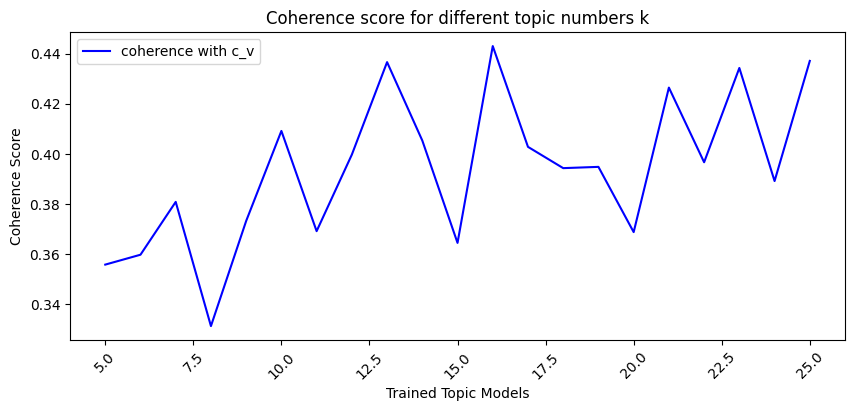

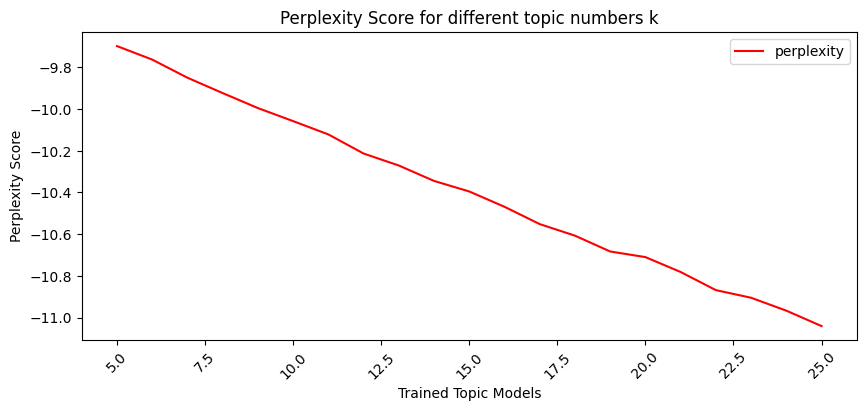

In [75]:
# Plotting Coherence Scores
plt.figure(figsize=(10,4))
plt.plot([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], k_coherence_values_cv, label ='coherence with c_v', color='blue')
plt.title("Coherence score for different topic numbers k")
plt.xlabel("Trained Topic Models")
plt.ylabel("Coherence Score")
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Variables/k16/Optimization_NumTopics_5-25_CoherenceScores.svg')
plt.show()

# Plotting Perplexity Scores
plt.figure(figsize=(10,4))
plt.plot([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], k_perplexity_values, label ='perplexity', color='red')
plt.title("Perplexity Score for different topic numbers k")
plt.xlabel("Trained Topic Models")
plt.ylabel("Perplexity Score")
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Variables/k16/Optimization_NumTopics_5-25_PerplexityScores.svg')
plt.show()

As it can be seen from the plots, **perplexity** does not really help to find the optimal number of topics *k*, as it decreases with an increasing number of topics *k* and therefore advocates for a really high number of topics which might not be helpful in the end.

### Parameter Optimization with Optimal *k*:

Conducting another Topic Modeling Process with the optimal number for *k* from the training above. Below, other parameters are tuned as well.

In [76]:
# initializing random seed to be able to reproduce the results
np.random.seed(13)

# running the function to find the optimal combination of parameters
model_list_cv, perplexity_values, coherence_values_cv, topic_coherence_values_cv, model_names = compute_quality_measures(dictionary=id2word, 
                                                                                                                         corpus=corpus, 
                                                                                        texts=data_bigrams_trigrams, 
                                                                                        coherence="c_v", 
                                                                                        iterations = 50,
                                                                                        topic_optim = [16], 
                                                                                        update_optim = [0, 1, 50, 100, 300, 500, 1000, 2000], 
                                                                                        alpha_optim = ['symmetric', 'asymmetric', 'auto'],
                                                                                        eta_optim = ['symmetric', 'auto'])

   topics_num:  16    update_interval:  0    alpha_value:  symmetric    eta_value:  symmetric    coherence 0.3921950891428083
   topics_num:  16    update_interval:  0    alpha_value:  symmetric    eta_value:  auto    coherence 0.3986445667573422
   topics_num:  16    update_interval:  0    alpha_value:  asymmetric    eta_value:  symmetric    coherence 0.3749948045092264
   topics_num:  16    update_interval:  0    alpha_value:  asymmetric    eta_value:  auto    coherence 0.3879204421384001
   topics_num:  16    update_interval:  0    alpha_value:  auto    eta_value:  symmetric    coherence 0.39351669915705423
   topics_num:  16    update_interval:  0    alpha_value:  auto    eta_value:  auto    coherence 0.3824307470249316
   topics_num:  16    update_interval:  1    alpha_value:  symmetric    eta_value:  symmetric    coherence 0.3795811621090848
   topics_num:  16    update_interval:  1    alpha_value:  symmetric    eta_value:  auto    coherence 0.40876311433675
   topics_num:  16   

In [77]:
# saving the variables

save_object('Variables/k16/', '16_model_list_cv.pckl', model_list_cv)
save_object('Variables/k16/', '16_perplexity_values.pckl', perplexity_values)
save_object('Variables/k16/', '16_coherence_values_cv.pckl', coherence_values_cv)
save_object('Variables/k16/', '16_topic_coherence_values.pckl', topic_coherence_values_cv)
save_object('Variables/k16/', '16_model_names.pckl', model_names)

In [25]:
# opening the variables
model_list_cv = open_variable('Variables/k17/', '17_model_list_cv.pckl')
coherence_values_cv = open_variable('Variables/k17/', '17_coherence_values_cv.pckl')
topic_coherence_values = open_variable('Variables/k17/', '17_topic_coherence_values.pckl')
model_names = open_variable('Variables/k17/', '17_model_names.pckl')
perplexity_values = open_variable('Variables/k17/', '17_perplexity_values.pckl')

### Plotting the Results for Optimizing *k*:

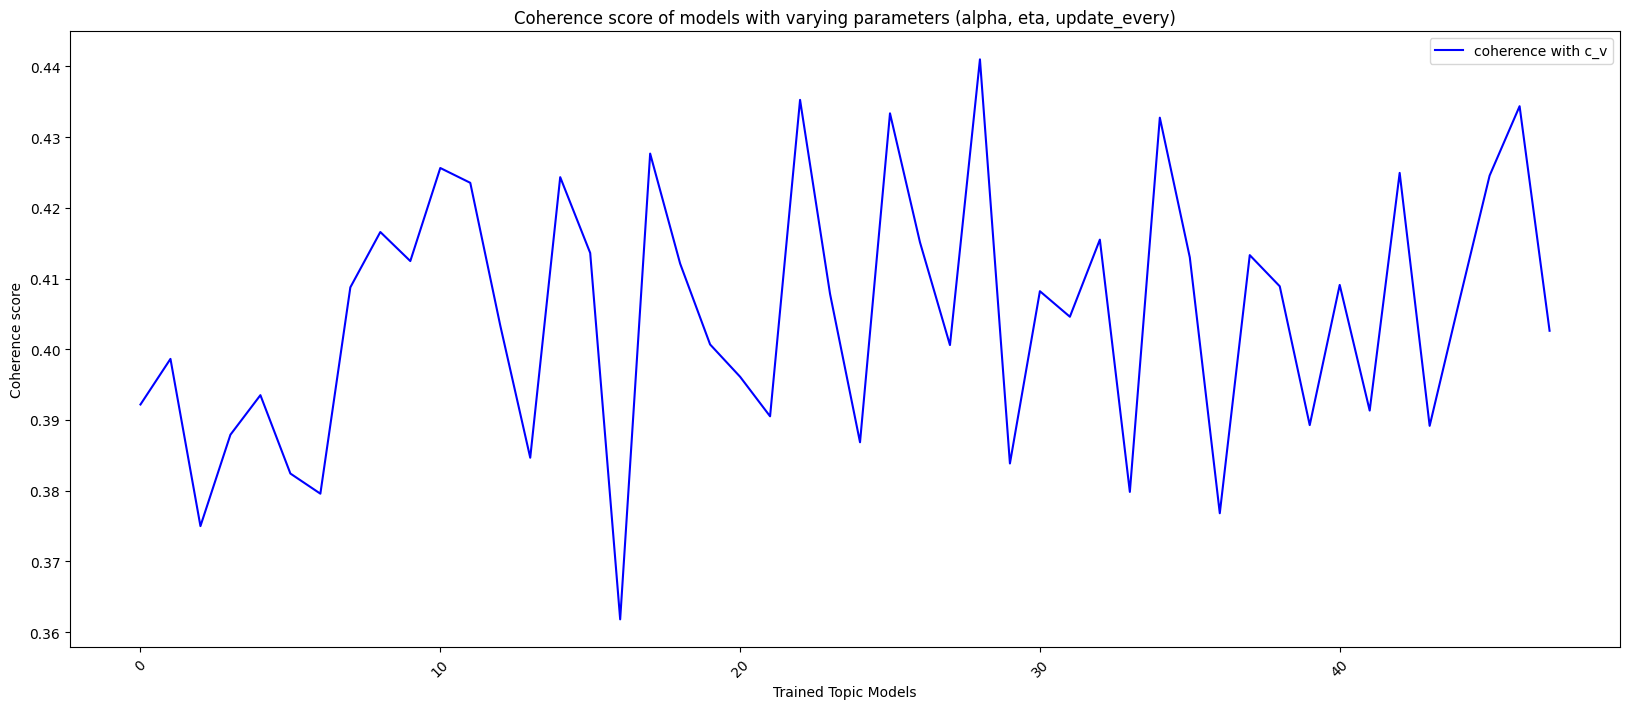

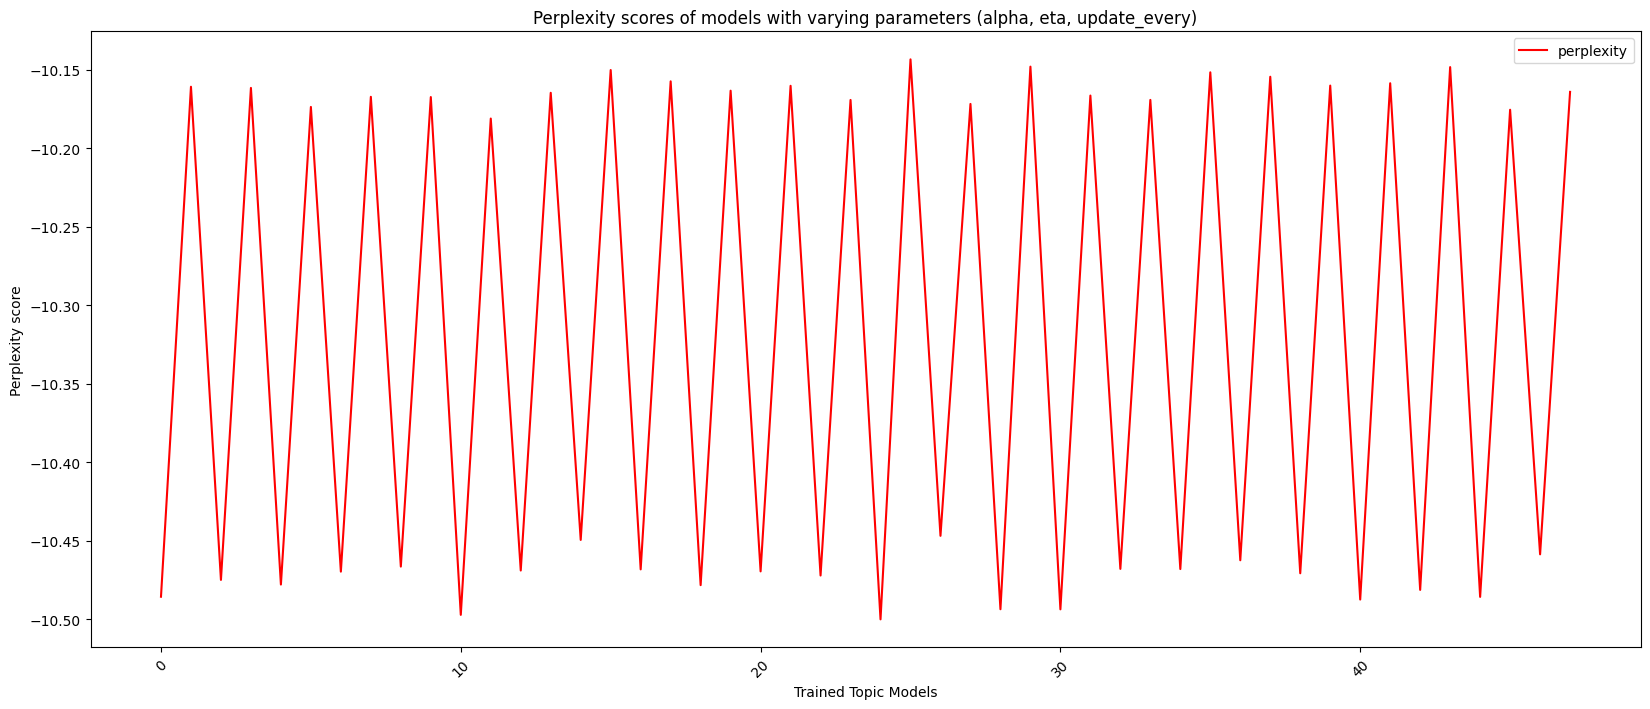

In [78]:
# Customizing and saving the plot
make_index = []
i = 0
for i in range(len(model_names)):
    make_index.append(i)
    i += 1

plt.figure(figsize=(20,8))
plt.plot(make_index, coherence_values_cv, label ='coherence with c_v', color='blue')
plt.title("Coherence score of models with varying parameters (alpha, eta, update_every)")
plt.xlabel("Trained Topic Models")
plt.ylabel("Coherence score")
# plt.vlines(x = 47.5, ymin=0, ymax=0.4, color='green', label='change in topic number k')
# plt.vlines(x = 95.5, ymin=0, ymax=0.4, color='green')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Variables/k16/Coherence_k16_HyperpOptim.svg')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(make_index, perplexity_values, label ='perplexity', color='red')
plt.title("Perplexity scores of models with varying parameters (alpha, eta, update_every)")
plt.xlabel("Trained Topic Models")
plt.ylabel("Perplexity score")
# plt.vlines(x = 47.5, color='green', ymin=-14, ymax=-10, label='change in topic number k')
# plt.vlines(x = 95.5, ymin=-14, ymax=-10, color='green')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Variables/k16/Perplexity_k16_HyperpOptim.svg')
plt.show()

Finding the index with the highest coherence and saving that model for further use

In [79]:
highest_coherence = []
for value in coherence_values_cv:
    if value > 0.44:
        highest_coherence.append(coherence_values_cv.index(value))

for element in highest_coherence:
    print(model_names[element])
    print(element)
    print(coherence_values_cv[element])
    print("\n")
    

        

('16', '300', 'auto', 'symmetric')
28
0.44100543004477627




In [83]:
# index_best_model = coherence_values_cv.index(max(coherence_values_cv))

# Select the model and print the topics
optimal_model = k_model_list_cv[-4]
# optimal_model = model_list_cv[index_best_model]
print(k_coherence_values_cv[-4])
# print(coherence_values_cv[index_best_model])

# print('Number of topics in the best model: ', model_list_cv[index_best_model].num_topics)

## how to get the number of topics in the final/chosen model
# final_num_topics = model_list_cv[index_best_model].num_topics
final_num_topics = k_model_list_cv[-4].num_topics
print(final_num_topics)

# optimal_model.save("Models/optimal_model_n17.model", "w")

0.4594130119630901
22


==========================================================================================================================

==========================================================================================================================

==========================================================================================================================

## Research Question 1: Topic Modeling

### *Which topics can be found in the abstracts from DHd-conferences between 2014 and 2023 with Topic Modeling?*

Visualisation of final topic modeling with optimal parameters

In [84]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
# vis = pyLDAvis.gensim_models.prepare(hdp, corpus, id2word)
pyLDAvis.show(vis, local=False)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [19/Jun/2023 13:55:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2023 13:55:10] code 404, message Not Found
127.0.0.1 - - [19/Jun/2023 13:55:10] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


In [81]:
# model = gensim.models.ldamodel.LdaModel.load("models/optimal_model_n17.model")

### Further analyses with the optimal topic model from above

For all: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb

Getting the most frequent words per topic

In [30]:
optimal_model.show_topics(num_topics=final_num_topics)

[(0,
  '0.003*"modellierung" + 0.002*"ansatz" + 0.002*"medium" + 0.002*"objekt" + 0.002*"anwendung" + 0.002*"tools" + 0.002*"kategorie" + 0.002*"visualisierung" + 0.002*"bild" + 0.002*"romane"'),
 (1,
  '0.002*"datum" + 0.002*"suchen" + 0.002*"ergebnis" + 0.002*"dokument" + 0.002*"gruppe" + 0.002*"erisse" + 0.002*"tools" + 0.002*"sehen" + 0.002*"film" + 0.002*"visuell"'),
 (2,
  '0.004*"frage" + 0.003*"thema" + 0.002*"neu" + 0.002*"figur" + 0.002*"werk" + 0.002*"beitrag" + 0.002*"editioner" + 0.002*"archiv" + 0.002*"ressource" + 0.002*"inhalt"'),
 (3,
  '0.003*"objekt" + 0.003*"konzept" + 0.002*"dokument" + 0.002*"plattform" + 0.002*"nutzerinnen" + 0.002*"autor" + 0.002*"literarisch" + 0.002*"ergebnis" + 0.002*"verschieden" + 0.002*"sehen"'),
 (4,
  '0.003*"tools" + 0.002*"werk" + 0.002*"literarisch" + 0.002*"virtuell" + 0.002*"ansatz" + 0.002*"frage" + 0.002*"inhalt" + 0.002*"autor" + 0.002*"verschieden" + 0.002*"museum"'),
 (5,
  '0.002*"editioner" + 0.002*"datum" + 0.002*"technisch"

Showing the probabilities of a certain word to belong to the topics

In [50]:
optimal_model.get_term_topics('lexikalisch')

[(0, 0.00025501623),
 (1, 0.00031436473),
 (2, 0.00012226285),
 (3, 0.00014078649),
 (4, 0.00026945566),
 (5, 0.00021553019),
 (6, 0.00021211426),
 (7, 0.00065594196),
 (8, 0.00016458305),
 (9, 0.00020328643),
 (10, 0.00019183387),
 (11, 0.00024417927),
 (12, 0.00021988283),
 (13, 0.00024991168),
 (14, 0.00029828955),
 (15, 0.00023319668),
 (16, 0.00011625474),
 (17, 2.8780061e-05),
 (18, 0.00012445082),
 (19, 0.00011645637),
 (20, 5.8432368e-05),
 (21, 0.00022116465),
 (22, 5.208464e-05),
 (23, 0.00017408766),
 (24, 4.6406403e-05)]

==========================================================================================================================

==========================================================================================================================

==========================================================================================================================

## Research Question 2: Hierarchical Clustering and Topic Similarity

### *Which topics appear in one abstract frequently and therefore have a high topic similarity?*

### RQ2: Functions

- Function *find_topics_per_text*:

This function uses the built-in method *get_documemnt_topics* from LDA model in order to retrieve all topic probabilities for each of the texts. The probabilities are stored and returned by the function.

In [40]:
def find_topics_per_text(corpus):
    topics_per_text = []
    i = 0

    for text in corpus:
        doc_topics = optimal_model.get_document_topics(text)
        probabilities = []
        #saving the topic distribution of each text in a list
        for topic in doc_topics:
            topic_num, probability = topic
            probabilities.append(probability)
        topics_per_text.append(probabilities)
        i += 1    
    
    return topics_per_text

In [41]:
indexes = [0]
for sublist in docnames:
    indexes.append(len(sublist) + indexes[-1])
    
topics_per_text = find_topics_per_text(corpus)

In [198]:
# topics_per_text = []
# i = 0

# for text in corpus:
#     doc_topics = optimal_model.get_document_topics(text)
#     probabilities = []
#     #saving the topic distribution of each text in a list
#     for topic in doc_topics:
        
#         topic_num, probability = topic
#         probabilities.append(probability)
#     topics_per_text.append(probabilities)
#     i += 1    
# print(len(topics_per_text))


1203


C:\Windows\Temp\ipykernel_9404\3303844568.py:28: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(euclidean_distances, method='ward'), labels=range(final_num_topics), leaf_font_size=16)
C:\Windows\Temp\ipykernel_9404\3303844568.py:28: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(euclidean_distances, method='ward'), labels=range(final_num_topics), leaf_font_size=16)
C:\Windows\Temp\ipykernel_9404\3303844568.py:28: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(euclidean_distances, method='ward'), labels=range(final_num_topics), leaf_font_size=16)
C:\Windows\Temp\ipykernel_9404\3303844568.py:28: ClusterWarning:

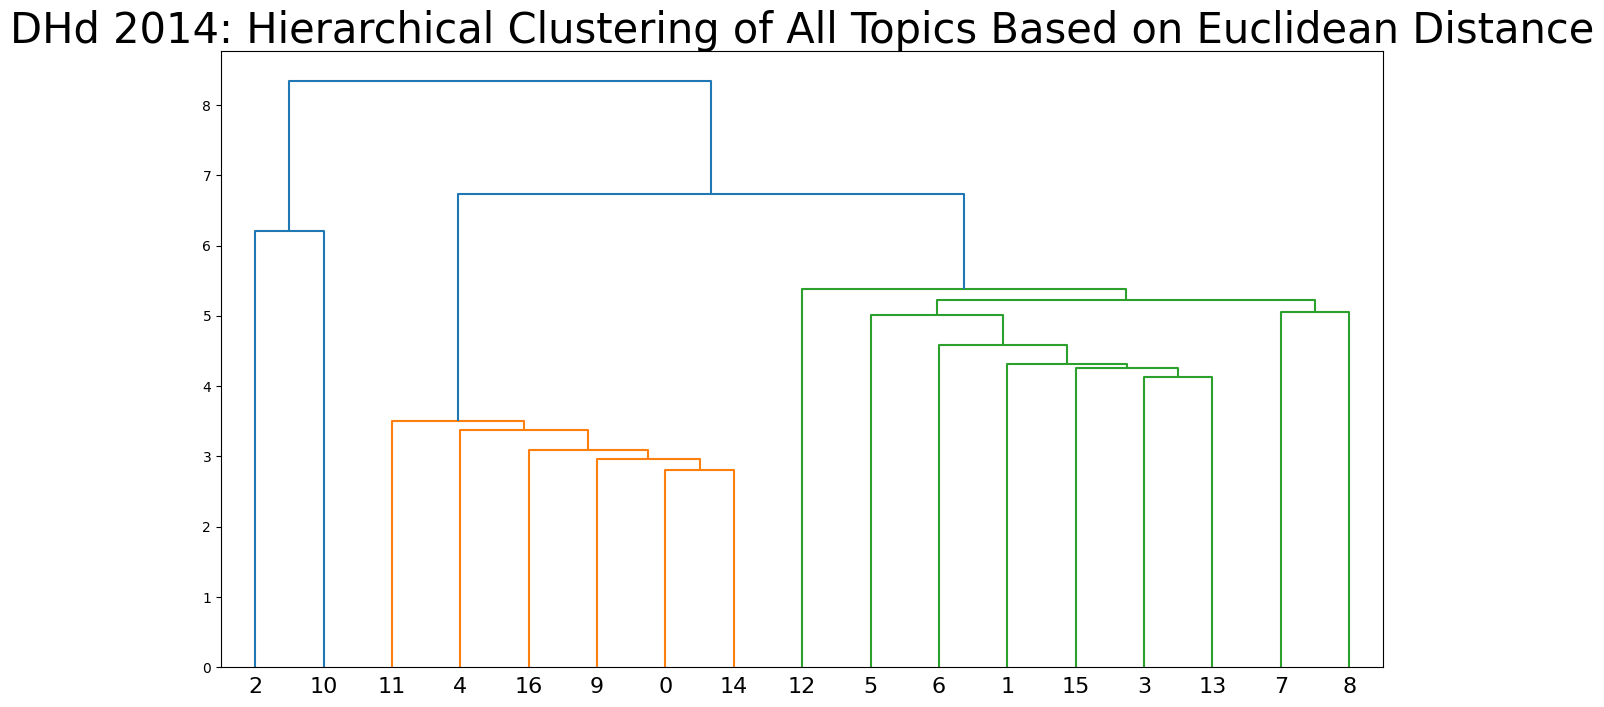

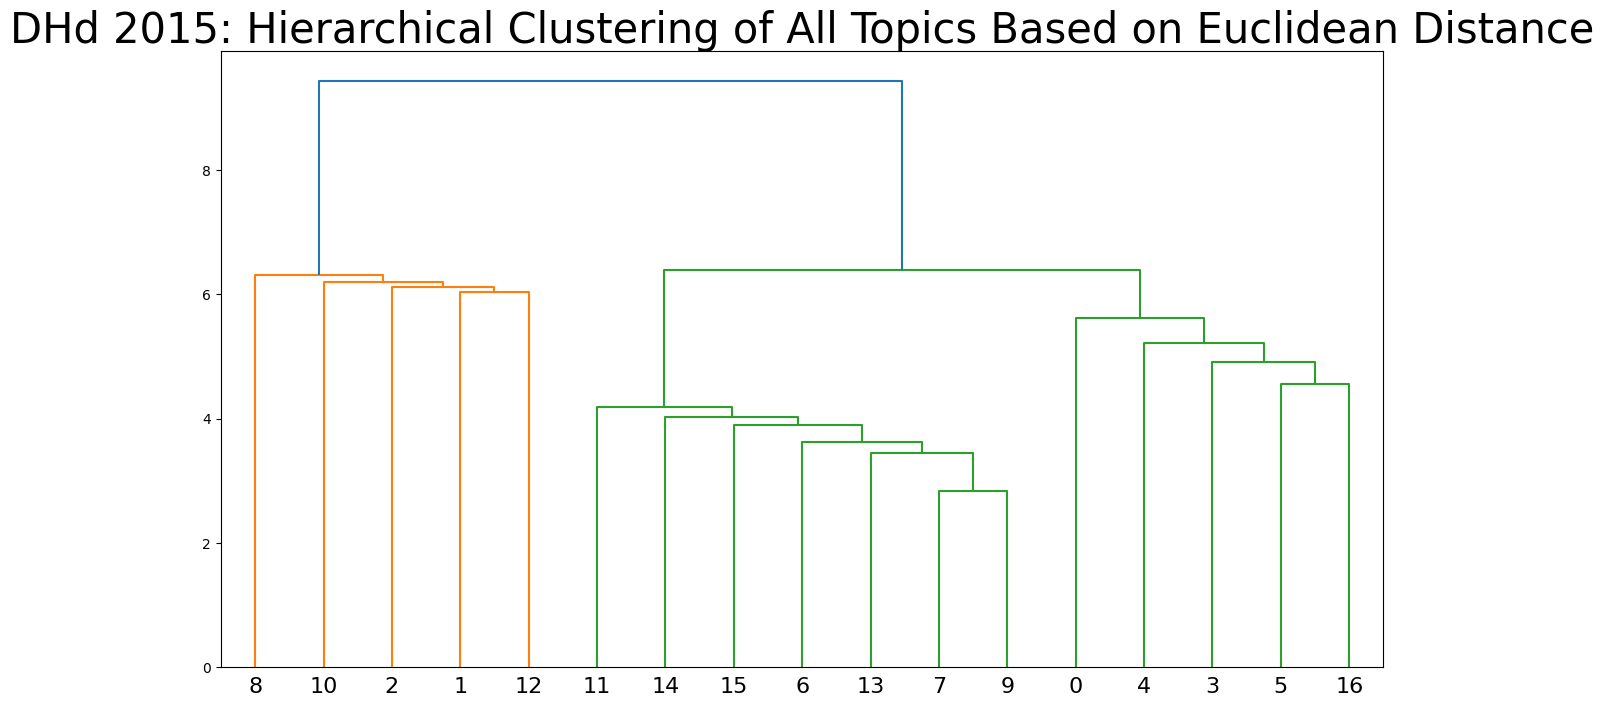

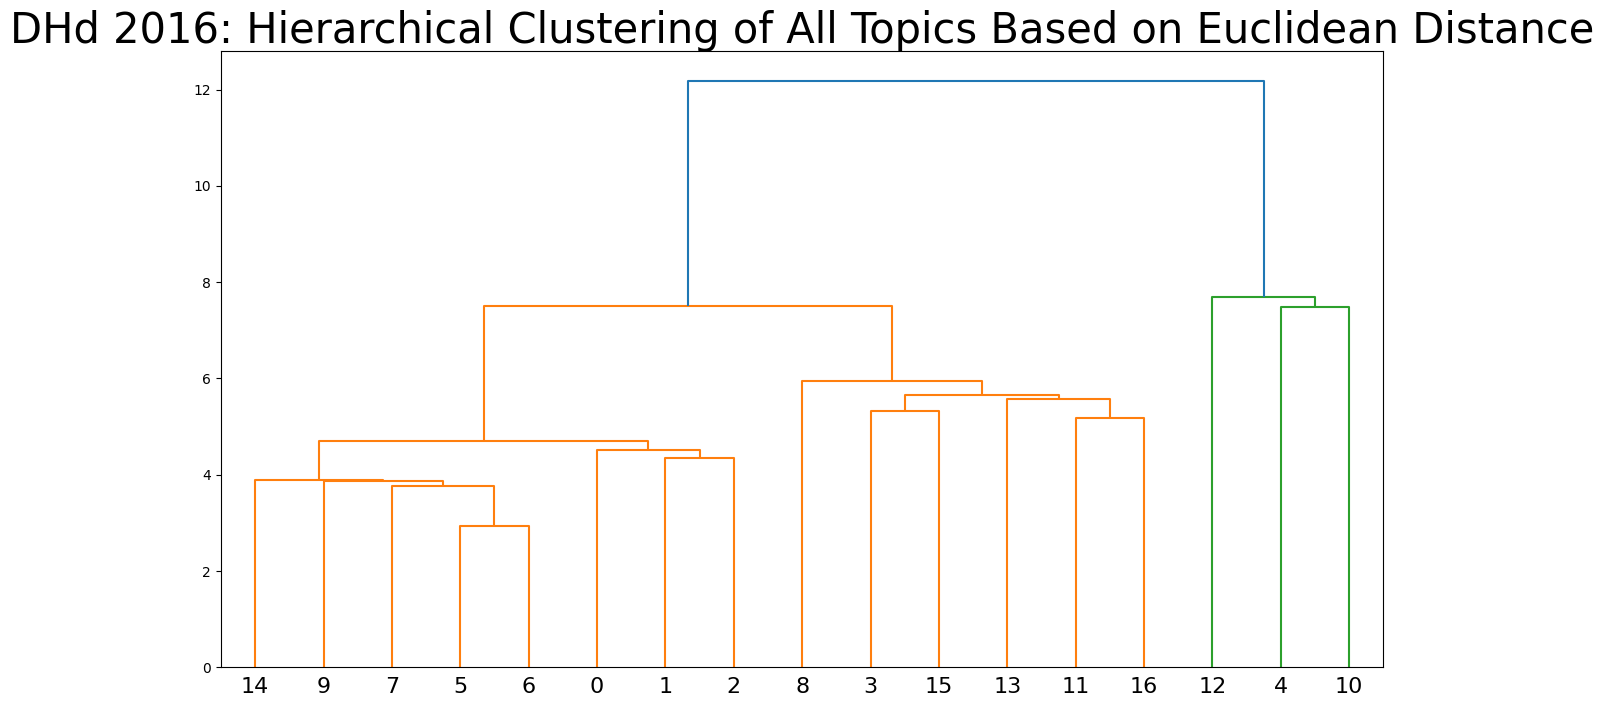

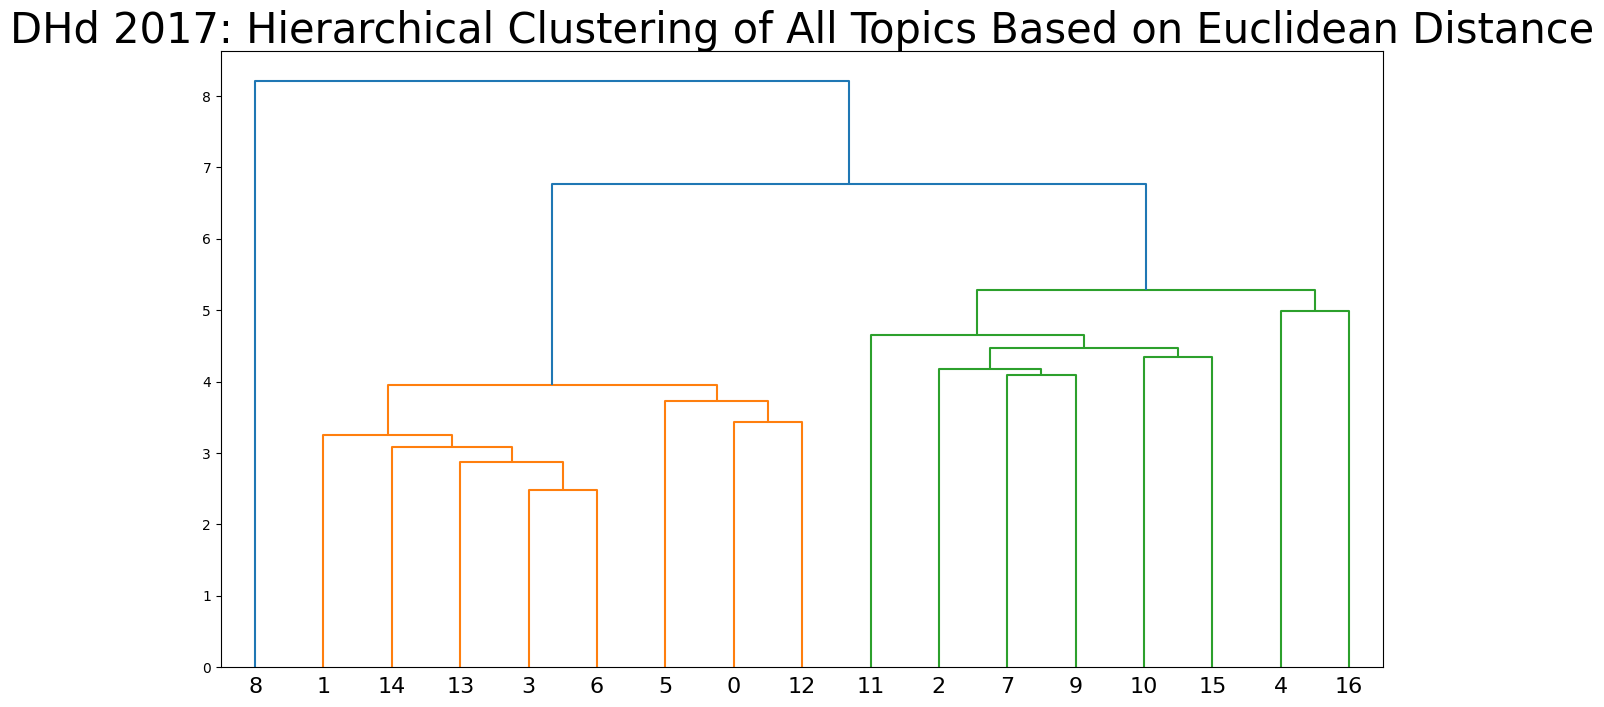

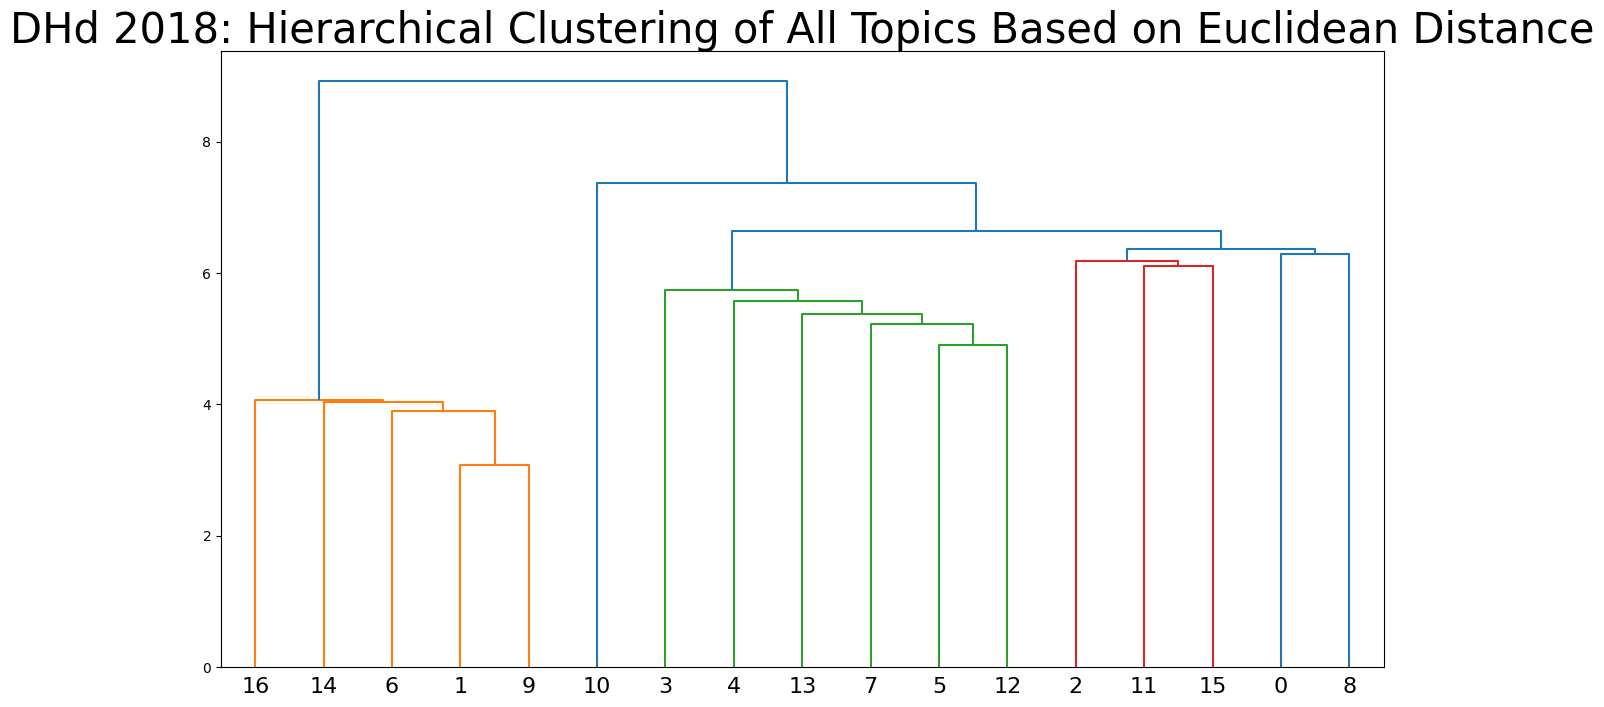

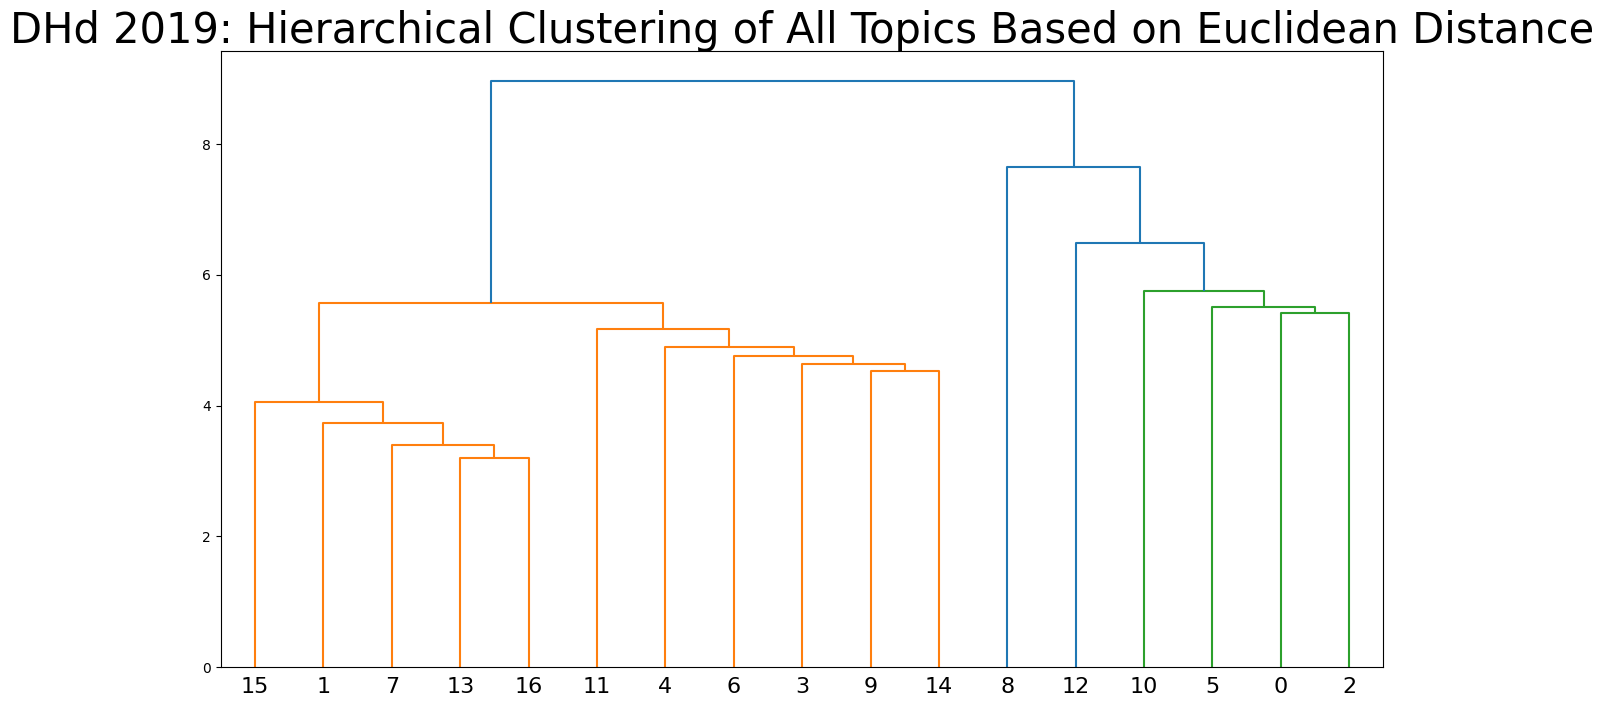

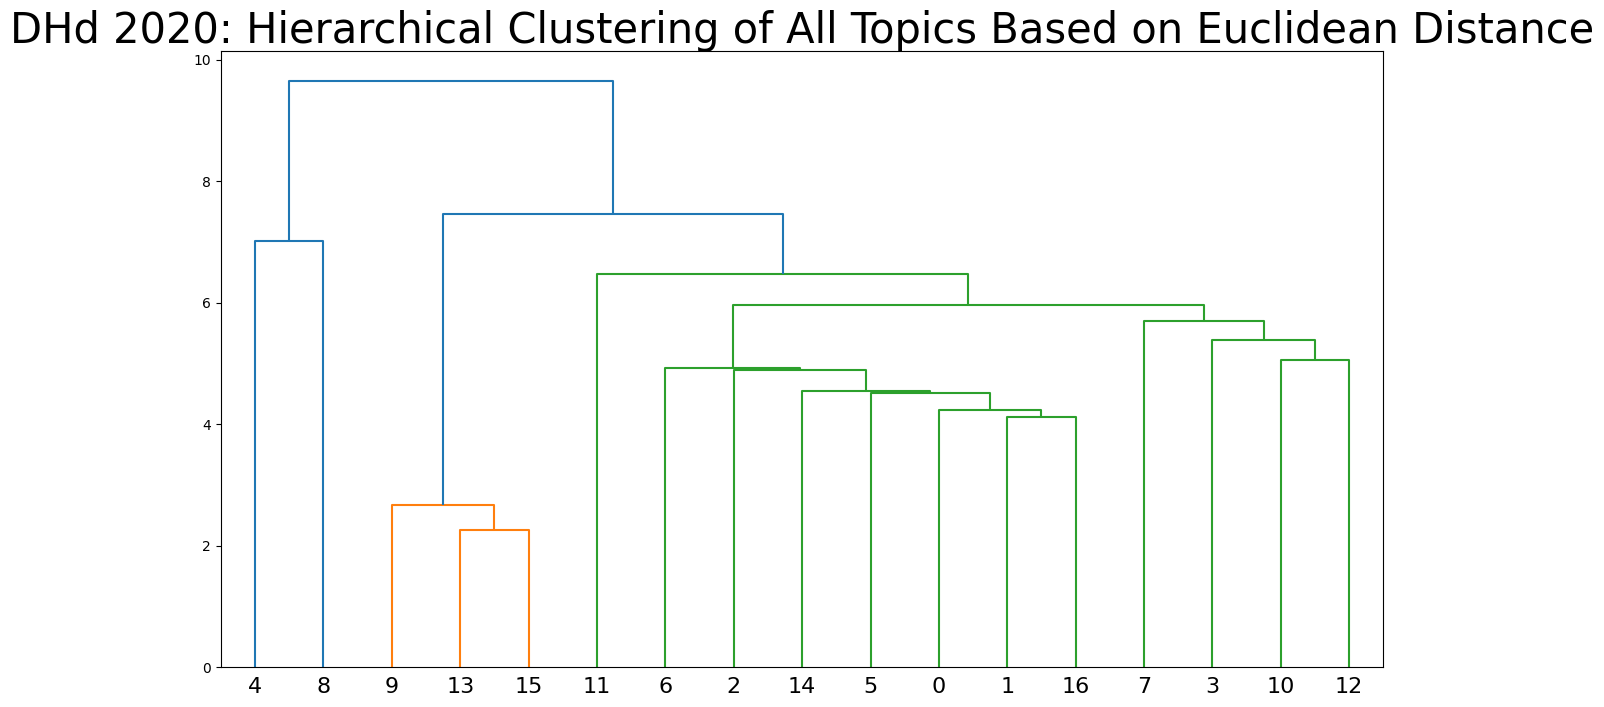

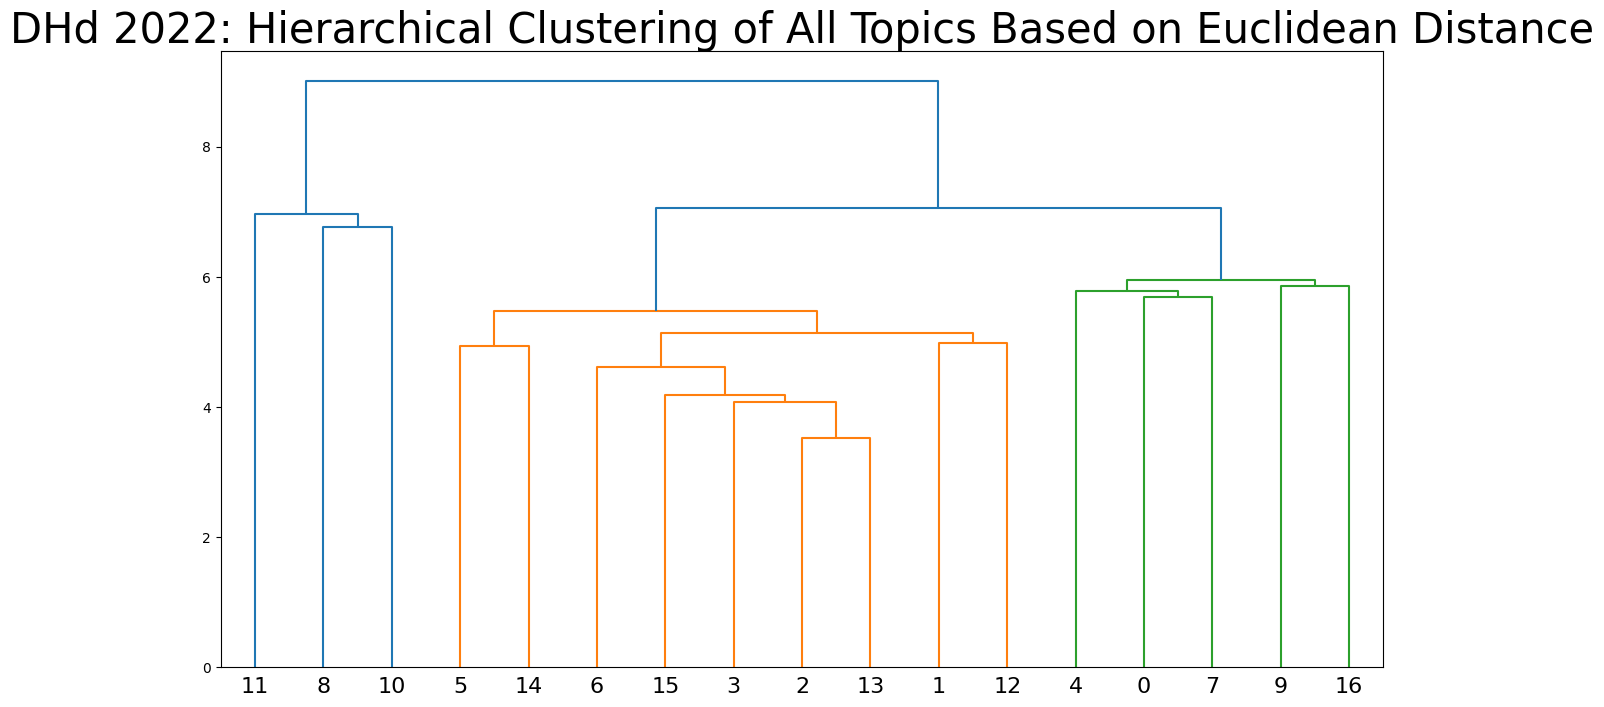

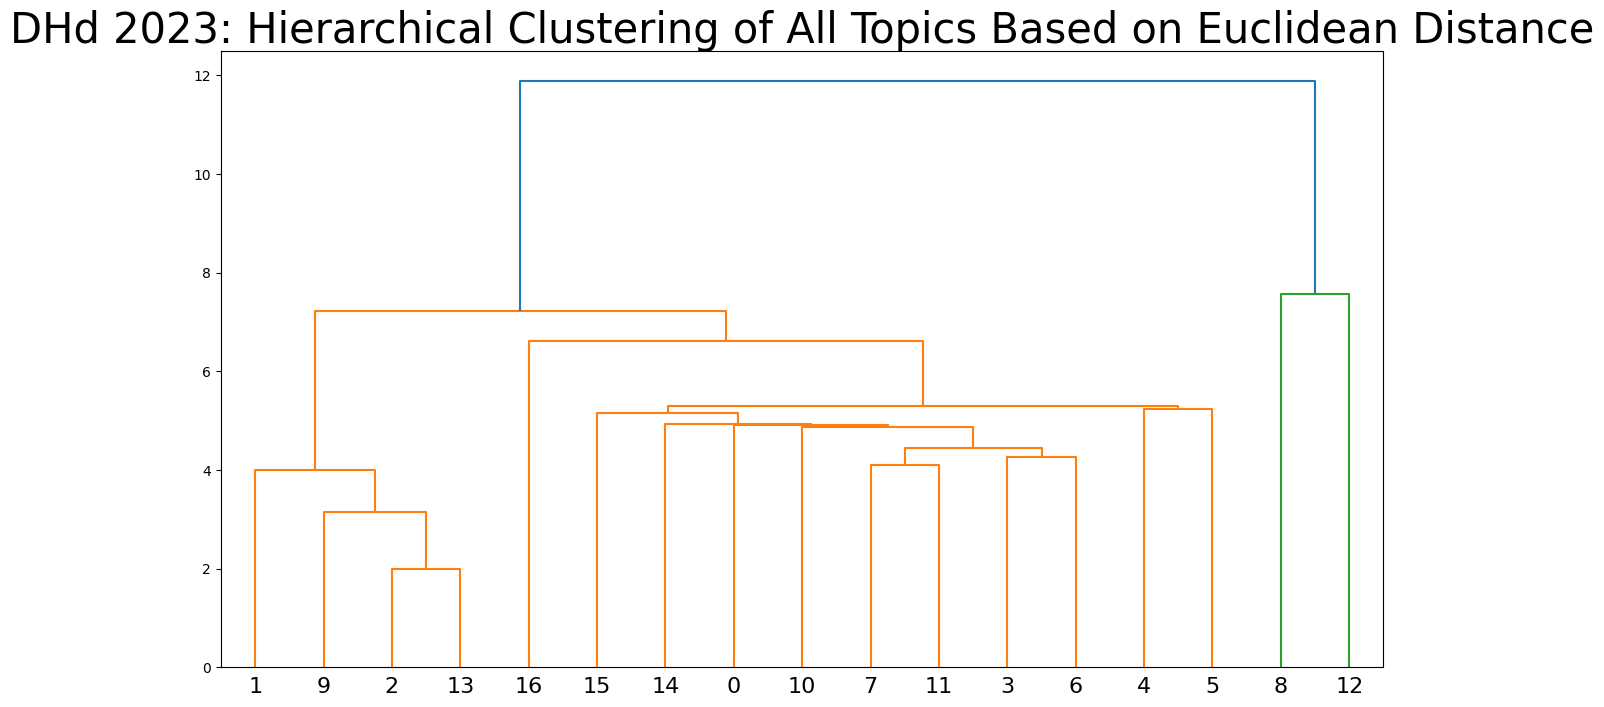

In [201]:
for j in range(0, len(indexes)-1):
    data = topics_per_text[indexes[j]:indexes[j+1]]
    
    # creating and transposing DataFrame to easily extract each first, second, third value in the lists
    df_averages = pd.DataFrame(data=data).T
    # topic_vectors contains a list for each year in the observation
    # each list contains the probability of the respective topic for each text of the year, therefore each list is as long as the indexes indicate
    # therefore, topic_vectors[0][0] contains topic 0's probabilities from all texts from DHd 2014 
    topic_vectors_years = []

    for i in range(0, final_num_topics):
        topic_vectors_years.append(df_averages.iloc[i].values)

    # calculating the distance of each topic's topic distribution to any other topics' distribution with Euclidean Distance 
    euclidean_distances_years = []
    for top in topic_vectors_years:
        vec_distances = []
        # comparing the distance between the topic distribution of one text to the distribution of all other texts
        for comparison in topic_vectors_years:
            vec_distances.append(math.dist(top, comparison))
        # returns list of lists, in which the distance of each document to each other document is saved    
        euclidean_distances_years.append(vec_distances)


    plt.figure(figsize=(15, 8))  
    name = filenames[j][-8:]
    plt.title((name + ': Hierarchical Clustering of All Topics Based on Euclidean Distance'), fontsize = 30) 
    dend = shc.dendrogram(shc.linkage(euclidean_distances_years, method='ward'), labels=range(final_num_topics), leaf_font_size=16)
    plt.savefig(('Figures/RQ2/RQ2_Clustering'+ name+'.svg'), format='svg')


C:\Windows\Temp\ipykernel_9404\3783292006.py:27: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(euclidean_distances, method='ward'), labels=range(final_num_topics), leaf_font_size=16)


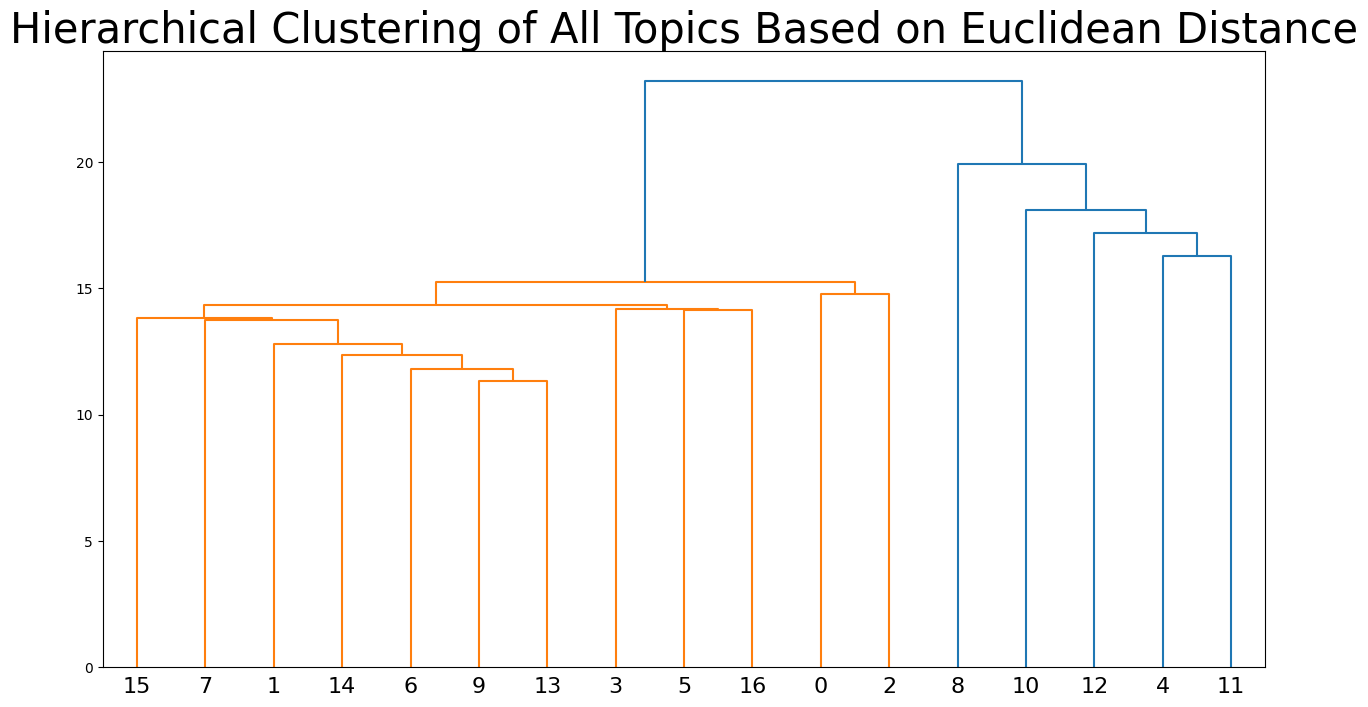

In [196]:
''' Diese und obere Zelle zusammenlegen? '''
# creating DataFrame to easily extract each first, second, third value in the lists
df_averages = pd.DataFrame(data=topics_per_text).T
topic_vectors_years = []

for i in range(0, final_num_topics):
    topic_vectors_years.append(df_averages.iloc[i].values)


# calculating the distance of each topic's topic distribution to any other topics' distribution with Hellinger Distance 
euclidean_distances_years = []
for top in topic_vectors_years:
    vec_distances = []
    # comparing the distance between the topic distribution of one text to the distribution of all other texts
    for comparison in topic_vectors_years:
        vec_distances.append(math.dist(top, comparison))
    # returns list of lists, in which the distance of each document to each other document is saved    
    euclidean_distances_years.append(vec_distances)


plt.figure(figsize=(15, 8))  
plt.title('Hierarchical Clustering of All Topics Based on Euclidean Distance', fontsize = 30) 
dend = shc.dendrogram(shc.linkage(euclidean_distances_years, method='ward'), labels=range(final_num_topics), leaf_font_size=16)
plt.savefig('Figures/RQ2/RQ2_Clustering_AllYears.svg', format='svg')

Drin lassen oder weg? 

In [42]:
"""
topics_per_text = []
i = 0

## als Input: Liste von Listen der einzelnen Texte in lemmatisierter/bigramm-Form!

for text in data_bigrams_trigrams:
    #bow-representation of the single text
    bow = optimal_model.id2word.doc2bow(text)
    doc_topics, word_topics, phi_values = optimal_model.get_document_topics(bow, per_word_topics=True)
    
    # #shows the distribution of topics in the single documents
    # print(i, doc_topics)
    
    #saving the topic distribution of each text in a list
    topics_per_text.append(doc_topics)
    i += 1
    
# calculating the distance of each document's topic distribution to any other document's topic distribution with Hellinger Distance 
hellinger_distances = []
for doc in topics_per_text:
    doc_distances = []
    # comparing the distance between the topic distribution of one text to the distribution of all other texts
    for comparison in topics_per_text:
        doc_distances.append(hellinger(doc, comparison))
    # returns list of lists, in which the distance of each document to each other document is saved    
    hellinger_distances.append(doc_distances)
    
"""


"\ntopics_per_text = []\ni = 0\n\n## als Input: Liste von Listen der einzelnen Texte in lemmatisierter/bigramm-Form!\n\nfor text in data_bigrams_trigrams:\n    #bow-representation of the single text\n    bow = optimal_model.id2word.doc2bow(text)\n    doc_topics, word_topics, phi_values = optimal_model.get_document_topics(bow, per_word_topics=True)\n    \n    # #shows the distribution of topics in the single documents\n    # print(i, doc_topics)\n    \n    #saving the topic distribution of each text in a list\n    topics_per_text.append(doc_topics)\n    i += 1\n    \n# calculating the distance of each document's topic distribution to any other document's topic distribution with Hellinger Distance \nhellinger_distances = []\nfor doc in topics_per_text:\n    doc_distances = []\n    # comparing the distance between the topic distribution of one text to the distribution of all other texts\n    for comparison in topics_per_text:\n        doc_distances.append(hellinger(doc, comparison))\n    

Visualization of Hellinger-Distance in a dendrogram

In [43]:
"""
# to label texts with their names and not just index numbers
all_names = []
for sublist in docnames:
    all_names = all_names + sublist

for i in range(0, len(indexes)-2):
    
    plt.figure(figsize=(150, 25))  
    plt.title(filenames[i] + ": Hierarchical Clustering of Documents based on Hellinger Distance", fontsize = 30) 

    dend = shc.dendrogram(shc.linkage(hellinger_distances[indexes[i]:indexes[i+1]], method='ward'), labels=all_names[indexes[i]:indexes[i+1]], leaf_rotation=90, leaf_font_size=14)
    
    name = 'Figures/RQ2/RQ2__Dendrogramm_Hellinger_Distances_' + str(filenames[i]) + '.svg'
    plt.savefig(name, format='svg')
    i += 1
"""

'\n# to label texts with their names and not just index numbers\nall_names = []\nfor sublist in docnames:\n    all_names = all_names + sublist\n\nfor i in range(0, len(indexes)-2):\n    \n    plt.figure(figsize=(150, 25))  \n    plt.title(filenames[i] + ": Hierarchical Clustering of Documents based on Hellinger Distance", fontsize = 30) \n\n    dend = shc.dendrogram(shc.linkage(hellinger_distances[indexes[i]:indexes[i+1]], method=\'ward\'), labels=all_names[indexes[i]:indexes[i+1]], leaf_rotation=90, leaf_font_size=14)\n    \n    name = \'Figures/RQ2/RQ2__Dendrogramm_Hellinger_Distances_\' + str(filenames[i]) + \'.svg\'\n    plt.savefig(name, format=\'svg\')\n    i += 1\n'

==========================================================================================================================

==========================================================================================================================

==========================================================================================================================

## Research Question 3: Mann-Kendall-Test

### *How have the topics been changing throughout the years - which trends are perceptible?*


Mann-Kendall-Test:

- MK-Test analyzes whether there is a trend in a topic's appearance over time: increasing, decreasing, no trend (Chen et al., 2020; Mann, 1945)
- results are statistically significant if p <= 0.05
- results are highly statistically significant if p <= 0.01
- [Further Information on Mann-Kendall-Test](https://www.geeksforgeeks.org/how-to-perform-a-mann-kendall-trend-test-in-python/)


### RQ3: Functions

- Function *calculate_topic_average*:

This function takes the list of indexes for each year's corpus as well as the lists of topics per text as input. The latter one contains a list of probabilities for every topic for every text in the coprus. On the basis of those probabilites and separated by the DHd-year the texts belong to, the average probability of each topic within each conference year is calculated. Those averages are then stored in another list, which is returned.

In [33]:
# def calculate_topic_average(indexes, topics_per_text):
#     # calculating the average probability of a certain topic per year
#     averages_per_topic_per_year = []
#     i = 0 
#     j = 1
#     while i < int(len(indexes)-1):
#         all_probs = []
#         for text in topics_per_text[indexes[i]:indexes[j]]:
#             probs = []
#             for tuple in text:
#                 topic, probability = tuple
#                 # extracting only the probability values from the tuple
#                 probs.append(probability)
#             all_probs.append(probs)
#         # dividing the sum of all first, second, third... values by the number of values to get the average of all n topics for one year
#         averages_per_topic = (np.sum(all_probs, axis=0)/len(all_probs))
#         averages_per_topic_per_year.append(averages_per_topic)
#         i +=1
#         j += 1
#     return averages_per_topic_per_year

def calculate_topic_average(indexes, topics_per_text):
    # calculating the average probability of a certain topic per year
    averages_per_topic_per_year = []
    i = 0 
    j = 1
    while i < int(len(indexes)-1):
        all_probs = []
        for text in topics_per_text[indexes[i]:indexes[j]]:
            all_probs.append(text)
        # dividing the sum of all first, second, third... values by the number of values to get the average of all n topics for one year
        averages_per_topic = (np.sum(all_probs, axis=0)/len(all_probs))
        averages_per_topic_per_year.append(averages_per_topic)
        i +=1
        j += 1
    return averages_per_topic_per_year

### RQ3: Main

In [44]:
# using the list of names of documents for each year to count how many documents belong to one year
topic_averages = calculate_topic_average(indexes, topics_per_text)

# creating a dataframe which shows the average probability of a topic in each year
df_averages = pd.DataFrame(topic_averages, index=filenames).T


# conducting the Mann-Kendall-Test for each of the topics
df_mk = []
for i in range(0, final_num_topics):
    df_mk.append(mk.original_test(df_averages.values[i]))
mk_results = pd.DataFrame(df_mk)

# joining the averages-DF and the Mann-Kendall-Test-DF in order to have complete csv-file
mk_df = df_averages.join(mk_results)
mk_df.to_csv('Figures/RQ3/RQ3__Mann-Kendall.csv')

### RQ3: Line Plot Visualization

In [53]:
# dividing up the number of topics in order to plot understandable graphs 
parts = [0, round(final_num_topics*0.3), round(final_num_topics*0.6), final_num_topics]

for k in range(len(parts)-1):
    line_chart = pygal.Line(x_title='Years Observed', y_title='Average Probability of the Topic')
    line_chart.title = 'Average Probabilities of Topics over the Years'
    line_chart.x_labels = filenames
    for i in range(parts[k], parts[k+1]):
        line_chart.add(str('Topic ' + str(i)), df_averages.values[i])
    
    name = 'Figures/RQ3/RQ3__TopicProbabilitiesPerYear_' + str(parts[k]) + '-' + str((parts[k+1]-1)) + '.svg'
    line_chart.render_to_file(name) 

==========================================================================================================================

==========================================================================================================================

==========================================================================================================================

## Research Question 4: Development and Use of Research Methods
### *With regard to the use of different scientific methods, which developments are perceptible?*

There are two types of keywords used in the xml-files of the DHd-Conferences: \<keywords n="topics" scheme="ConfTool"> and \<keywords n="keywords" scheme="ConfTool">. The former may be used by authors to freely annotate their xml-file with words which they want to be in the metadata, while the latter one only allows for a selection of keywords.
From 2016 on, authors to the conference could select keywords to be used in the xml-file to their contribution. The list of keywords is 75 items long, out of which six can currently be selected for the xml-file. Yet, in 2016 and 2017, this restriction has not been made, so that authors could select more than six keywords for the metadata. The full list of usable keywords is called 'conf_tool_methods' and will be used in the following.


### RQ4: Functions

- Function *count_keywords*:

This function is the first to be called for RQ4 and takes two lists as input arguments. The first one contains all freely-assigned keywords which were used in all xml-texts from 2016 until 2023. This list is then used to create a dictionary for counting the used methods. At first, all values to the keys, which are the methods' names, are set to 0, but then the second list provided will be iterated over and the values of the methods are added to. This happens for each DHd-year separately, so that the sorted list returned by *count_keywords* provides an overview of which methods were used how often in which year.

- Function *find_popular_methods*:

*find_popular_methods* takes the list provided by *count_keywords* as input and extracts the first five entries for each year. Those entries are the five most-often used keywords for the respective year and they are added to a list which stores the most popular methods. The list is returned by the function.

- Function *calculate_relative_count*:

The function takes as input the popular keywords extracted in the previous function, the sorted list of counted keywords from *count_keywords* as well as a list stating how many xml-files are in each conference year's corpus. The function's purpose, in the first step, is to find out how often each of the popular keywords is used over the years, i.e. over all corpora. As a second step, this count of the method is then divided by the number of documents in the corpus in order to compute relative instead of absolute numbers. This is necessary because there are larger and smaller corpora in the collection, which could distort the interpretation of numbers. 

In [106]:
def count_keywords(complete_list, year_list):
    
    # for each year, a large list of all possible, freely annotated keywords is set up and the count for each of the keywords is set to 0
    # if the method appears in the specific year's list, +1 will be added to the count
     
    big_list = []
    for year in year_list:
        dict = {}
        for method in complete_list:
            dict[method] = 0
        for method in year:
                dict[method] += 1
        # sorting the dict according to the count, so that the item with the highest count comes first
        sorted_dict = sorted(dict.items(), key=lambda x: x[1], reverse=True)
        big_list.append(sorted_dict)
        
    return big_list

In [101]:
def find_popular_methods(methods):
    # takes sorted list as input in which the methods used and their count (how often were they used/stated as keyword in each year?) is saved
    popular_methods = []
    for year in methods:
        # extracts the first five methods (the ones with the highest count) and appends them to another list, in which only the method itself is saved
        best_five = year[:5]
        for item in best_five: 
            res_method, count = item
            if res_method not in popular_methods:
                popular_methods.append(res_method)
                
    return popular_methods

In [79]:
def calculate_relative_count(popular_methods, count_keywords, number_xml_docs):
    
    # for the popular methods, it is looked at how often they appear in each year's corpus
    # then, that count will be divided by the total number of texts in that corpus, which results in a proportional frequency of the keyword to the corpus size 
    relative_dict = {}
    for item in popular_methods:
        item_count = []
        for year in count_keywords:
            i = 0
            for tuple in year:
                name, count = tuple
                if name == item:
                    item_count.append(round(count/number_xml_docs[i], 3))
            i += 1
        relative_dict[item] = item_count
        
    return relative_dict

### RQ4: Main (Both Types of Keywords)

In [91]:
# how many texts are in each year's corpus taken into account?
number_xml_docs = [len(sublist) for sublist in doc_names_xml]
  
# analysing the freely-selected keywords in <keywords n='topics'>
count_free_keywords = count_keywords(all_free_keywords, used_keywords_free)
popular_free_methods = find_popular_methods(count_free_keywords)
free_relative = calculate_relative_count(popular_free_methods, count_free_keywords, number_xml_docs)

# analysis of predetermined keywords in <keywords n='keywords'>
count_conf_keywords = count_keywords(conf_tool_methods, used_keywords_conf)
popular_conf_methods = find_popular_methods(count_conf_keywords)
conf_relative = calculate_relative_count(popular_conf_methods, count_conf_keywords, number_xml_docs)

[['Methodik', 'Faksimile', 'Codierung', 'Befund und Deutung', 'digitale 3D-Rekonstruktion', 'Grundlagen', 'Datenmodellierung', 'Dokumentation', 'Visualisierung', 'Vernetzung', 'Übergreifend', 'regional', 'Kommunikation', 'Diskussion', 'Datenzentren', 'Nachhaltigkeit', 'Forschungsdaten', 'Datenkuratierung', 'Use Case', 'Infrastruktur', 'CLARIN-D', 'Aufbewahren', 'Digitale Editionen', 'Infrastruktur', 'Visualisierung', 'Modellierung', 'korpusbasierte Untersuchungen historischer Sprachstufen', 'Tokenisierung', 'Lemmatisierung', 'Annotation', 'verschiedene frühneuhochdeutsche Textkorpora', 'Benutzerintegration', 'Crowdsourcing', 'Edition', 'Georeferecing', 'Retrieval', 'Lehrbuch', 'Kollaboration', 'Open Access', 'Forschungsdatenmanagement', 'Kostümsprache', 'Mustersprache', 'Ähnlichkeitsanalyse', 'Empirische Filmanalyse', 'Daten Visualisierung', 'digitales Publizieren', 'Autorschaft', 'Review-Verfahren', 'Open Access', 'Langzeitarchivierung', 'Korpora', 'Sociale Medien', 'Social Media', 'I

### RQ4: Line Chart Visualization and CSV (Freely Selectable Keywords)

In [108]:
# creating a plot for visualisation

line_chart = pygal.Line(x_title='Years Observed', y_title= 'Number of Usages Per Method, Relative to Corpus Size')
line_chart.title = 'Use of methods in <keywords n=\'topics\'>'
line_chart.x_labels = filenames_xml
for key in free_relative:
  line_chart.add(key, free_relative[key])

line_chart.render_to_file('Figures/RQ4/RQ4__Free_ResearchMethodsPerYear.svg')

In [37]:
# for complete information, a csv-file is provided with all used keywords and their relative counts
free_relative_all = calculate_relative_count(all_free_keywords, count_free_keywords, number_xml_docs)
df_averages = pd.DataFrame(free_relative_all.values(), index=free_relative_all.keys(),columns=filenames_xml)
df_averages.to_csv('Figures/RQ4/RQ4__Free_Keywords_All.csv')

### RQ4: Line Chart Visualization and CSV (Freely Selectable Keywords)

In [110]:
# creating a plot for visualisation

line_chart = pygal.Line(x_title='Years Observed', y_title= 'Number of Usages Per Method, Relative to Corpus Size')
line_chart.title = 'Use of methods in <keywords n=\'keywords\'>'
line_chart.x_labels = filenames_xml
for key in conf_relative:
  line_chart.add(key, conf_relative[key])

line_chart.render_to_file('Figures/RQ4/RQ4__Conf_ResearchMethodsPerYear.svg')


In [111]:
# for complete information, a csv-file is provided with all used keywords and their relative counts
conf_relative_all = calculate_relative_count(conf_tool_methods, count_conf_keywords, number_xml_docs)
df_averages = pd.DataFrame(conf_relative_all.values(), index=conf_relative_all.keys(),columns=filenames_xml)
df_averages.to_csv('Figures/RQ4/RQ4__Conf_Keywords_All.csv')

==========================================================================================================================

==========================================================================================================================

==========================================================================================================================

## Research Question 5: Analysis of Authors and Teams of Authors


*Which researchers contribute to the conference particularly frequently with abstracts, in which teams do they contribute and how have the teams been changing?*

### RQ5: Functions

- Function *rank_authors*:

*rank_authors* takes as input the nested list of authors per text and per year, and turns it one large list containing every author who contributed the conference in one year. This list contains authors twice/three times if they contributed twice/three times within one conference, which is how eventually a count of every author and their contributions to the conferene is set up. The function returns a list of lists, in which the authors' names and their respective count of contributions for one year is stored. This function is necessary to set up the network nodes in a last step.

- Function *find_coauthors*:

The function *find_coauthors* takes the same list, *authors* as input. Differently to *rank_authors*, however, this function uses the input list to determine the coauthors of one year. This means that it extracts the authors who worked together in one single contribution in pairs and counts how often these pairs appear within one conference year. This function prepares the data for adding edges and their weight to the network.

- Function *find_new_authors*:

*find_new_authors* takes the output list from *rank_authors* as input and uses it to determine which authors have contributed to one conference but not the previous one. This is done by comparing the authors lists of one year with the one from the previous year. Those new authors are stored in a list, which is used in the setting up of the network in order to mark those new authors.

- Function *determine_edge_color*:

The function *determine_edge_color* is applied while setting up the network graphs. Based on the so-called coauthor-count, which is determined by the function *find_coauthors*, this function determines the color of the network's edges depending on how often the two authors have worked together in on conference year. 

In [54]:
def rank_authors(authors):
# returns list of authors and number of their appearances over the years
    authors_list_per_year = []
    all_counted_authors = []
    for year in authors:
        for team in year:
            authors_list_per_year = authors_list_per_year + team
        all_counted_authors.append(count_appearances(authors_list_per_year))
        authors_list_per_year = [] 

    return all_counted_authors

In [55]:
def find_coauthors(authors):
    coauthors_list = []
    coauthors_per_year = []

    for conference_year in authors:
        for document_authors in conference_year:
            if len(document_authors) >= 2:
                for i in range(len(document_authors)-1):
                    for j in range(i+1, len(document_authors), 1):
                        coauthors_list.append((document_authors[i], document_authors[j]))              
        dict_coauthors_count = count_appearances(coauthors_list)      
        coauthors_per_year.append(dict_coauthors_count) 
        coauthors_list = []
        
    return coauthors_per_year

In [97]:
# def find_new_authors(all_counted_authors):
#     # returns list of people who did not participate in the previous DHd conference
 
#     newbies_year = [[]]
#     for i in range(1, len(all_counted_authors)):
#         current_year = all_counted_authors[i]
#         prev_year = authors[i-1]
#         prev_authors = []
#         newbies = []
#         for item in prev_year:
#             prev_authors = prev_authors + item
                
#         for element in current_year:
#             name, count = element
#             if name not in prev_authors:
#                 newbies.append(name)
        
#         newbies_year.append(newbies) 

#     return newbies_year

def find_new_authors(all_counted_authors):
     # returns list of people who did not participate in the previous DHd conference
 
    new_author_year = [[]]
    new_author_general = [[]]
    all_prev_authors = []
    for i in range(1, len(all_counted_authors)):
        current_year = all_counted_authors[i]
        prev_year = authors[i-1]
        
        
        prev_authors = []
        current_new_authors = []
        completely_new_authors = []
        
        for item in prev_year:
            prev_authors = prev_authors + item
        all_prev_authors = all_prev_authors + prev_authors        
        for element in current_year:
            name, count = element
            if name not in prev_authors:
                current_new_authors.append(name)
            if name not in all_prev_authors:
                completely_new_authors.append(name)
                
        
        new_author_year.append(current_new_authors) 
        new_author_general.append(completely_new_authors)
        

    return new_author_year, new_author_general

In [57]:
def determine_edge_color(coauthor_count):
      # function to determine the color of the network's edges, depending on how often authors worked together in that year
      if coauthor_count >= 3:
            return '#360BFA'
      elif coauthor_count == 2:
            return '#6CADFB'
      else: 
        return '#6CEAFB'

### RQ5: Main

In [105]:
all_counted_authors = rank_authors(authors)
coauthors_per_year = find_coauthors(authors)
# save_object('Variables/', 'coauthors_per_year.pckl', coauthors_per_year)
current_new_authors, general_newbies = find_new_authors(all_counted_authors)

### RQ5: Network Visualizations
In the next few lines of code, the network itself is being created. The nodes have to be added as well as the edges and their weights. In the end, the general algorithm of the network as well as some other parameters are defined. 

In [108]:
# opening the provided HTML code which has to be added to the network html file
with open('Misc/LegendHTML.txt', "r", encoding='utf-8') as legend:
    html_addition = legend.read()

# implementing the network and statistics for each year
stats_current_new_authors = [0]
stats_completely_new_authors = [0]
i = 0
for year in filenames_xml:
      
  # implementing the network itself for each year
  g = Network(height='600px', width='100%', cdn_resources='remote', select_menu=True, font_color='black', filter_menu=True, neighborhood_highlight=True)
  nxg = nx.complete_graph(0)
  g.from_nx(nxg)
  
  # adding nodes for less frequent authors
  for author in all_counted_authors[i][10:]:
    name, total_count = author
    title = (name, total_count)
    g.add_node(name, 
              title=title, 
              label=name, 
              size=(total_count*10), 
              color='orange',
              borderWidth=1, 
              borderWidthSelected=3,
              shape='dot'
              )
    
  # adding nodes for the top 10 most contributing authors each year 
  """ Da hier einfach der Sortierung nach die ersten 10 Einträge genommen werden, gibt es auch Autoren mit gleich vielen Einträgen, die einen Kreis und keinen Stern bekommen """
  for author in all_counted_authors[i][:10]:
    name, total_count = author
    title = (name, total_count)
    g.add_node(name, 
              title=title, 
              label=name,
              size=(total_count*10), 
              color='orange',
              borderWidth=1, 
              borderWidthSelected=3,
              shape='star'
              )
  
  # changing the node colors for completely new authors and those who have not participated at the previous conference  
  if len(current_new_authors[i]) > 0:
    for author in current_new_authors[i]:
      g.get_node(author)['color'] = '#C70039'
    stats_current_new_authors.append(str(len(current_new_authors[i])-len(general_newbies[i]))+ '/'+ str(len(all_counted_authors[i])))
    
  if len(general_newbies[i]) > 0:
    for author in general_newbies[i]:
      g.get_node(author)['color'] = '#D32F8A'
    stats_completely_new_authors.append(str(len(general_newbies[i]))+ '/'+ str(len(all_counted_authors[i])))
    
      
  # adding the edges between authors, color depending on how often authors worked togehter
  for item in coauthors_per_year[i]:
    name1 = item[0][0]
    name2 = item[0][1]
    coauthor_count = item[1]
    col_select = determine_edge_color(coauthor_count)
    g.add_edge(name1, name2, 
              width=(coauthor_count),
              title=(coauthor_count),
              color = col_select
              )
  
  # writing an html-file
  html = g.generate_html()
  name = 'Figures/RQ5/RQ5__Authors_Networks_' + str(filenames_xml[i][-4:]) + '.html'
  with open(str(name), mode='w', encoding='utf-8') as fp:
    # finding the proper place in the html document and inserting the additional markup
    find = re.search(r'<div id="mynetwork" class="card-body"></div>', html)
    end = find.end()+1
    
    html = html[:end] + html_addition + html[end:]   
    fp.write(html)

  i += 1

### RQ5: Data Frame

In [107]:
d = {'Authors  Who Did Not Contribute At Previous Conference': stats_current_new_authors, 'Authors Who Never Contributed to Conference': stats_completely_new_authors}
df_averages = pd.DataFrame(data=d, index=filenames_xml)

         Authors  Who Did Not Contribute At Previous Conference   
DHd 2016                                                  0      \
DHd 2017                                              0/249       
DHd 2018                                             60/420       
DHd 2019                                             34/316       
DHd 2020                                             63/321       
DHd 2022                                             80/420       
DHd 2023                                             64/386       

         Authors Who Never Contributed to Conference  
DHd 2016                                           0  
DHd 2017                                     162/249  
DHd 2018                                     251/420  
DHd 2019                                     162/316  
DHd 2020                                     168/321  
DHd 2022                                     244/420  
DHd 2023                                     208/386  


==========================================================================================================================

==========================================================================================================================

==========================================================================================================================

## Research Question 6: Clustering of (Teams of) Authors and Certain Research Topics

### *Which clusters of researchers can be found with regard to topics and how have the clusters been changing?* 

### RQ6: Functions

- Function *get_main_topics*:

Considering each text from the xml part of the corpus (starting with index 231), this function determines which topic is the one with the highest probability. The function returns a dictionary which contains the text ids as keys and the number of the most prominent topic as values.

- Function *get_authors_and_topics*:

This function takes two lists and one dictionary as input. One list - authors_full_list - contains all author names extracted from the xml files, sorted alphabetically. The second list contains the authors of each text so that it can be determined which text was written by whom. The dictionary is the one returned by the function *get_main_topics*. These three input variables are used to infer which author has written on which (most salient) topic. This information is stored in the dictionary authors_and_topics, where each author name is a key and the values are lists containing the topics an author has written about. 
In order to make later visualizations more readible and understandable, the data is reduced to authors which have contributed in DHd-conferences at least three times. The reduced dictionary of authors and topics is returned by the function.

- Function *create_vectors*:

*create_vectors* takes the dictionary from *get_authors_and_topics* as input and transforms the information on the authors' contributions to topics into a sparse vector representation. Through this, a vector with the length of the final topic number is created for each author (i.e. key of the dictionary) that contains a 0 where the author did not contribute to a topic.  For topics the author contributed to, the vector contains an integer how often the author contributed to that topic. 
The function returns the dictionary with authors (keys) and vectors (values), as well as a list of only the vectors and a list of only the authors' names. 

In [80]:
def get_main_topics(all_topics):
#determines the topic with the highest probability for each text
    main_topics = {}
    i = 231
    # only takes into account the texts from the xml-files (starting with index 231), since only from then on the authors were noted down in markup
    for doc_topics, word_topics, phi_values in all_topics[231:]:
        # retrieve the item in doc_topics with highest second value in tuple
        most_salient_topics = max(doc_topics, key=itemgetter(1))
        topic_no, probability = most_salient_topics
        # filling the dictionary with the text IDs as keys and the most salient topics as values
        main_topics[i] = topic_no
        i += 1
        
    # returns a dictionary with text indexes as keys and the number of the salient topic as values
    return main_topics

In [81]:
def get_authors_and_topics(authors_full_list, all_texts_all_authors, main_topics):
    
    authors_and_topics = {}

    for name in sorted(authors_full_list):
        topics_per_author=[]
        text_id = 231
        # iterating over all authors in all texts, trying to find the 'key' currently looked at
        for text in all_texts_all_authors:
            for author in text:
                # if the key matches the author of the text, then note the text id and through that find the salient topic of the text
                if name == author:
                    text_topic = main_topics[text_id]
                    topics_per_author.append(text_topic)
                authors_and_topics[name] = topics_per_author 
            text_id +=1
    
    # reducing the list of authors so that only the authors with 3 or more contributions stay in the dictionary
    reduced_authors_and_topics = {}
    for key in authors_and_topics:
        if len(authors_and_topics[key]) > 2:
            reduced_authors_and_topics[key] = authors_and_topics[key]
    
    # return dictionary with author name as key and a list of topics as value
    return reduced_authors_and_topics   

In [82]:
def create_vectors(reduced_authors_and_topics):
    # transforming the data from reduced_authors_and_topics into a vector representation
    # advantage: easier to plot and counts how often each topic was written on by the authors
    vector = {}
    for key in reduced_authors_and_topics:
        vector[key] = [0]*final_num_topics
        for digit in reduced_authors_and_topics[key]:
            vector[key][digit] += 1
    # retrieving the author names to use them as labels and the vectors to determine distances between the vectors
    only_auth = [key for key in vector]
    only_vec = [vector[key] for key in vector]

    return vector, only_vec, only_auth

### RQ6: Main

In [83]:
# Main method for this RQ
all_topics = optimal_model.get_document_topics(corpus, per_word_topics=True)  

# retrieving all authors into one list
all_texts_all_authors = []
for year in authors:
    all_texts_all_authors = all_texts_all_authors + year
    
main_topics = get_main_topics(all_topics)
print(main_topics)
reduced_authors_and_topics = get_authors_and_topics(authors_full_list, all_texts_all_authors, main_topics)
vector, only_vec, only_auth = create_vectors(reduced_authors_and_topics)

{231: 4, 232: 12, 233: 10, 234: 12, 235: 12, 236: 8, 237: 11, 238: 3, 239: 3, 240: 6, 241: 8, 242: 9, 243: 2, 244: 12, 245: 8, 246: 10, 247: 10, 248: 13, 249: 4, 250: 4, 251: 3, 252: 15, 253: 0, 254: 11, 255: 12, 256: 11, 257: 8, 258: 13, 259: 7, 260: 9, 261: 8, 262: 16, 263: 12, 264: 4, 265: 10, 266: 7, 267: 4, 268: 10, 269: 6, 270: 12, 271: 1, 272: 13, 273: 8, 274: 8, 275: 10, 276: 2, 277: 8, 278: 8, 279: 10, 280: 15, 281: 9, 282: 12, 283: 15, 284: 14, 285: 3, 286: 0, 287: 12, 288: 13, 289: 1, 290: 15, 291: 15, 292: 12, 293: 14, 294: 15, 295: 9, 296: 11, 297: 5, 298: 16, 299: 16, 300: 13, 301: 13, 302: 13, 303: 5, 304: 0, 305: 11, 306: 12, 307: 3, 308: 10, 309: 1, 310: 10, 311: 15, 312: 11, 313: 1, 314: 14, 315: 4, 316: 9, 317: 12, 318: 16, 319: 8, 320: 7, 321: 10, 322: 10, 323: 14, 324: 10, 325: 10, 326: 10, 327: 16, 328: 11, 329: 12, 330: 1, 331: 4, 332: 4, 333: 11, 334: 13, 335: 11, 336: 11, 337: 15, 338: 2, 339: 2, 340: 4, 341: 10, 342: 2, 343: 1, 344: 12, 345: 0, 346: 8, 347: 3,

### RQ6: Dot Chart Visualization

In [87]:
# Visualization
custom_style = Style(
legend_font_size = 6,
legend_box_size = 6,
background='white',
plot_background='white',
foreground='black',
foreground_strong='#53A0E8',
foreground_subtle='#630C0D',
opacity='.6',
opacity_hover='0.3',
transition='400ms ease-in',
colors=('#E853A0', '#FB6707'))

# dividing the dictionary into several lists, to make the output plot more readible      
part1 = dict(list(vector.items())[:round(len(vector)*0.25)])
part2 = dict(list(vector.items())[round(len(vector)*0.25):round(len(vector)*0.5)])
part3 = dict(list(vector.items())[round(len(vector)*0.5):round(len(vector)*0.75)])
part4 = dict(list(vector.items())[round(len(vector)*0.75):])


i = 1
for part in [part1, part2, part3, part4]:
    dot_chart = pygal.Dot(human_readable=True, width = 800, height= 1000, truncate_legend=20, style=custom_style, legend_box_size=6)
    dot_chart.title = 'Most salient topic of each text'
    dot_chart.x_labels = range(final_num_topics)
    for key in part:
        dot_chart.add(key, part[key])

    # dot_chart.render_in_browser(human_readable=True)
    name = 'Figures/RQ6/RQ6__Authors_and_Topics_' + str(i) + '.svg'
    dot_chart.render_to_file(name)
    i += 1


### RQ6: Dendrogramm Visualization

C:\Windows\Temp\ipykernel_6524\693564201.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distances)


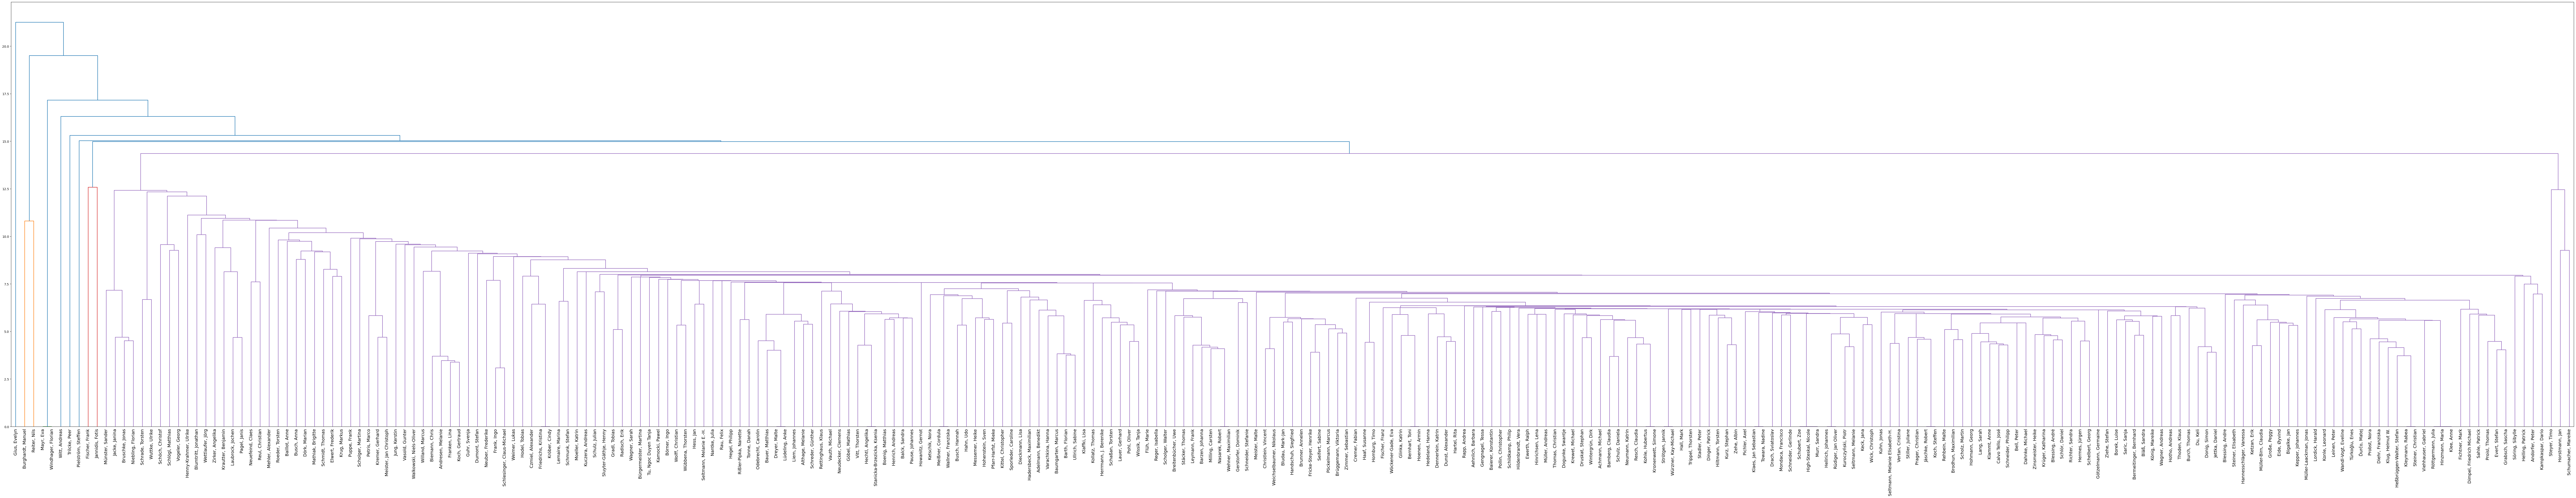

In [36]:
# creating a distance matrix between the vectors
distances = distance_matrix(only_vec, only_vec)

# creating a dendrogram
Z = hierarchy.linkage(distances)
plt.figure(figsize=(150, 25))
dn = hierarchy.dendrogram(Z, labels=only_auth, distance_sort=True, leaf_rotation = 90, leaf_font_size=14)
plt.savefig('Figures/RQ6/RQ6__Dendrogram.svg')